In [1]:
import missingno
from datetime import datetime
from dateutil.parser import parse
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn import preprocessing
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
import pylab as pl
import numpy as np
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_predict
import time

In [2]:
raw_data = pd.read_csv('../Melbourne_housing_FULL.csv')
raw_data.head()

Suburb             Address  Rooms Type      Price Method SellerG  \
0  Abbotsford       68 Studley St      2    h        NaN     SS  Jellis   
1  Abbotsford        85 Turner St      2    h  1480000.0      S  Biggin   
2  Abbotsford     25 Bloomburg St      2    h  1035000.0      S  Biggin   
3  Abbotsford  18/659 Victoria St      3    u        NaN     VB  Rounds   
4  Abbotsford        5 Charles St      3    h  1465000.0     SP  Biggin   

        Date  Distance  Postcode  ...  Bathroom  Car  Landsize  BuildingArea  \
0  3/09/2016       2.5    3067.0  ...       1.0  1.0     126.0           NaN   
1  3/12/2016       2.5    3067.0  ...       1.0  1.0     202.0           NaN   
2  4/02/2016       2.5    3067.0  ...       1.0  0.0     156.0          79.0   
3  4/02/2016       2.5    3067.0  ...       2.0  1.0       0.0           NaN   
4  4/03/2017       2.5    3067.0  ...       2.0  0.0     134.0         150.0   

   YearBuilt         CouncilArea Lattitude  Longtitude             Regionname  \
0        NaN  Yarra City Council  -37.8014    144.9958  Northern Metropolitan   
1        NaN  Yarra City Council  -37.7996    144.9984  Northern Metropolitan   
2     1900.0  Yarra City Council  -37.8079    144.9934  Northern Metropolitan   
3        NaN  Yarra City Council  -37.8114    145.0116  Northern Metropolitan   
4     1900.0  Yarra City Council  -37.8093    144.9944  Northern Metropolitan   

  Propertycount  
0        4019.0  
1        4019.0  
2        4019.0  
3        4019.0  
4        4019.0  

[5 rows x 21 columns]

In [3]:
raw_data.isna().sum()

Suburb               0
Address              0
Rooms                0
Type                 0
Price             7610
Method               0
SellerG              0
Date                 0
Distance             1
Postcode             1
Bedroom2          8217
Bathroom          8226
Car               8728
Landsize         11810
BuildingArea     21115
YearBuilt        19306
CouncilArea          3
Lattitude         7976
Longtitude        7976
Regionname           3
Propertycount        3
dtype: int64

In [4]:
raw_data[pd.isna(raw_data['CouncilArea'])]

Suburb           Address  Rooms Type     Price Method SellerG  \
18523    Footscray  2/16 Stafford St      2    u  710000.0      S     Jas   
26888   Camberwell   2/3 Kingsley St      2    h  825000.0     VB  Jellis   
29483  Fawkner Lot      1/3 Brian St      3    h  616000.0     SP    Brad   

             Date  Distance  Postcode  ...  Bathroom  Car  Landsize  \
18523  15/07/2017       5.1    3011.0  ...       NaN  NaN       NaN   
26888  11/11/2017       7.7    3124.0  ...       NaN  NaN       NaN   
29483   6/01/2018       NaN       NaN  ...       NaN  NaN       NaN   

       BuildingArea  YearBuilt  CouncilArea Lattitude  Longtitude  Regionname  \
18523           NaN        NaN          NaN       NaN         NaN         NaN   
26888           NaN        NaN          NaN       NaN         NaN         NaN   
29483           NaN        NaN          NaN       NaN         NaN         NaN   

      Propertycount  
18523           NaN  
26888           NaN  
29483           NaN  

[3 rows x 21 columns]

# Remove rows with missing Price

In [5]:
raw_data.dropna(subset=['Price'], inplace=True)

In [6]:
raw_data.nunique()

Suburb             345
Address          26751
Rooms               12
Type                 3
Price             2871
Method               5
SellerG            349
Date                78
Distance           213
Postcode           209
Bedroom2            14
Bathroom            10
Car                 13
Landsize          1557
BuildingArea       662
YearBuilt          151
CouncilArea         33
Lattitude        11366
Longtitude       12275
Regionname           8
Propertycount      336
dtype: int64

In [7]:
raw_data.agg(['min','median','max',np.mean])

Suburb          Address      Rooms Type         Price Method  \
min     Abbotsford  1 Aberfeldie Wy   1.000000    h  8.500000e+04     PI   
max       viewbank    9b Stewart St  16.000000    u  1.120000e+07     VB   
median         NaN              NaN   3.000000  NaN  8.700000e+05    NaN   
mean           NaN              NaN   2.992293  NaN  1.050173e+06    NaN   

        SellerG       Date   Distance    Postcode   Bedroom2  Bathroom  \
min     @Realty  1/07/2017   0.000000  3000.00000   0.000000  0.000000   
max       iTRAK  9/12/2017  48.100000  3978.00000  20.000000  9.000000   
median      NaN        NaN  10.500000  3088.00000   3.000000  1.000000   
mean        NaN        NaN  11.280276  3113.79608   3.046237  1.591683   

             Car       Landsize  BuildingArea    YearBuilt  Lattitude  \
min      0.00000       0.000000      0.000000  1196.000000 -38.190430   
max     18.00000  433014.000000  44515.000000  2019.000000 -37.397800   
median   2.00000     512.000000    133.000000  1970.000000 -37.800460   
mean     1.71537     593.488933    156.834586  1966.609153 -37.806963   

        Longtitude  Propertycount  
min     144.423790      83.000000  
max     145.526350   21650.000000  
median  145.003200    6567.000000  
mean    144.996711    7566.781089

In [8]:
#Drop columns
raw_data.drop(columns=['SellerG','Date','Postcode','Regionname'], inplace=True)

# Checkpoint 1

<AxesSubplot:>

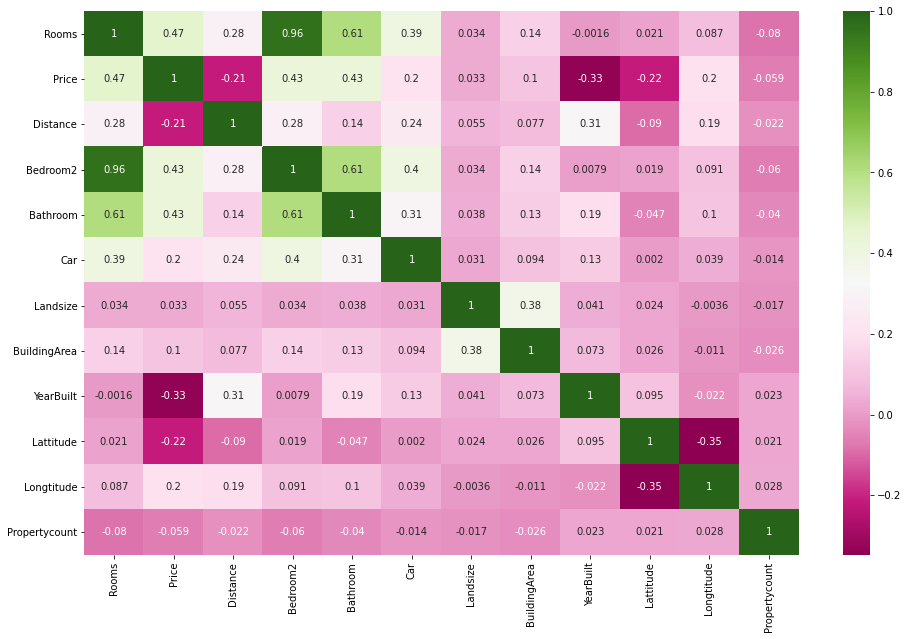

In [9]:
plt.figure(figsize=(16, 10))
sns.heatmap(raw_data.corr(), annot=True, cmap="PiYG")

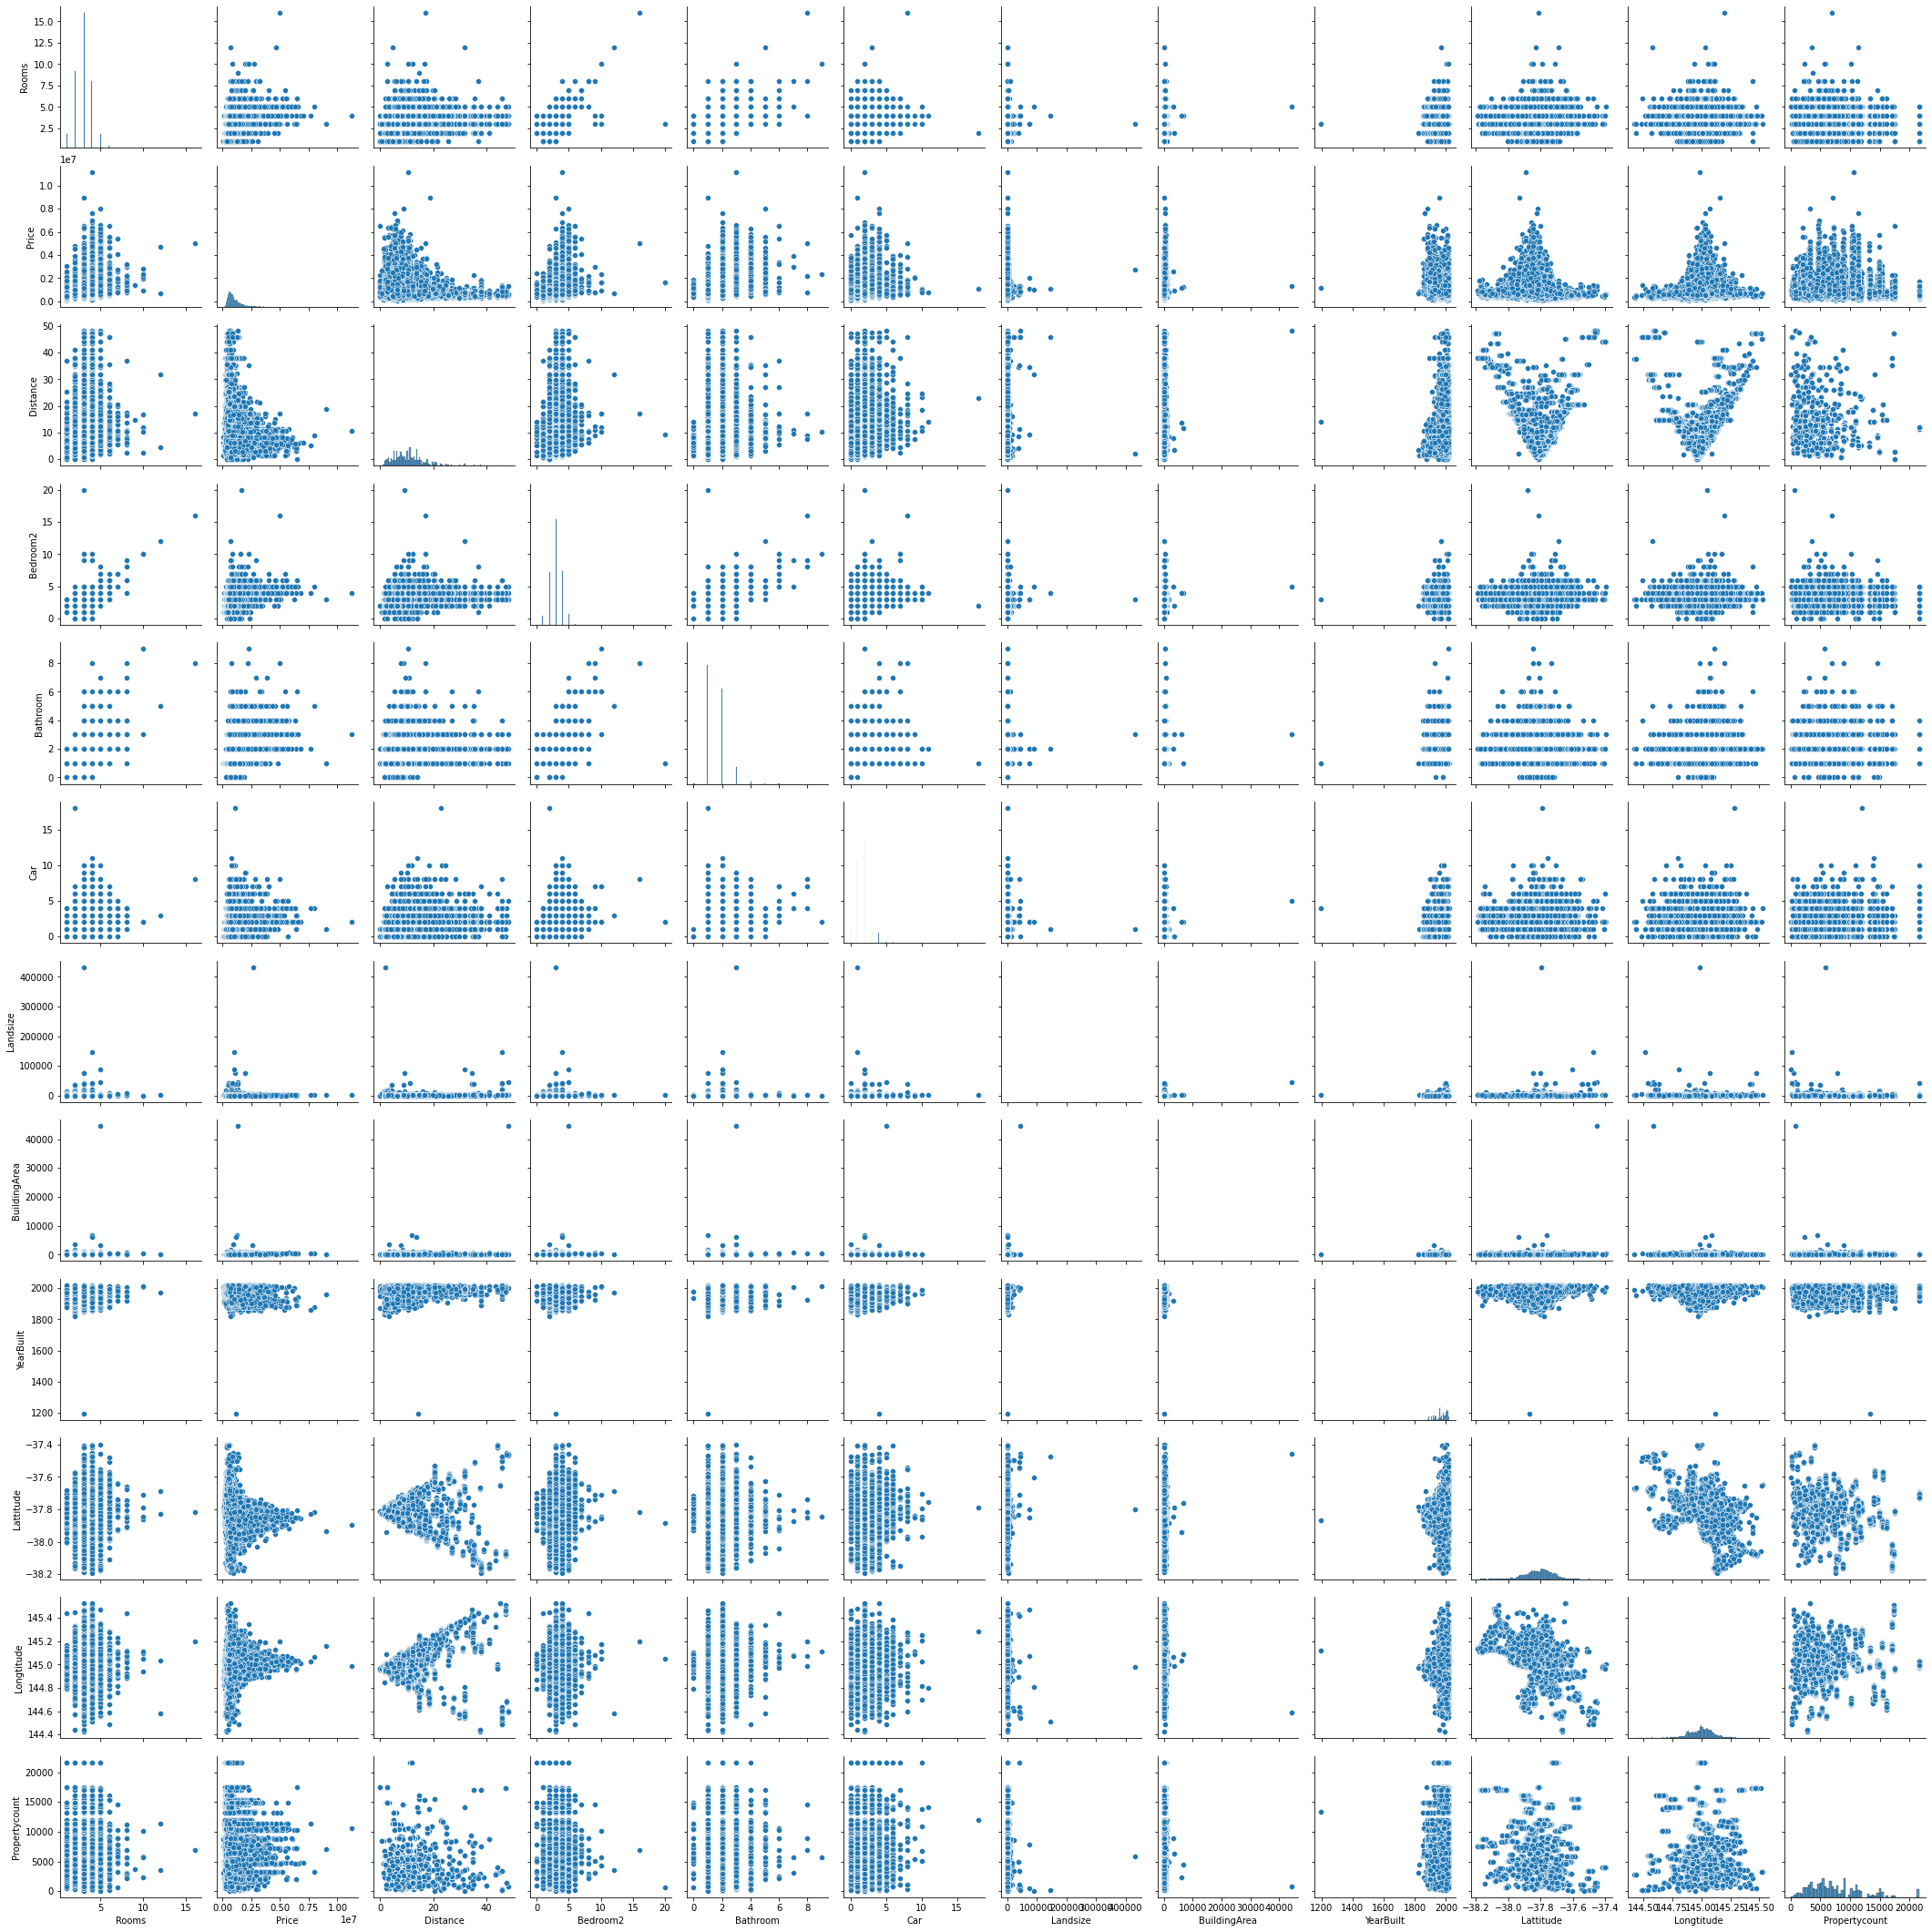

In [10]:
sns.pairplot(raw_data)

<AxesSubplot:>

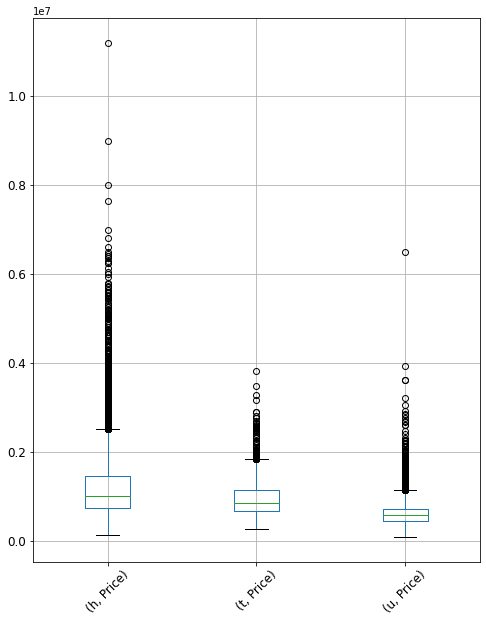

In [11]:
raw_data[['Type','Price']].groupby('Type').boxplot(rot=45, fontsize=12, figsize=(8,10), subplots=False)

<AxesSubplot:>

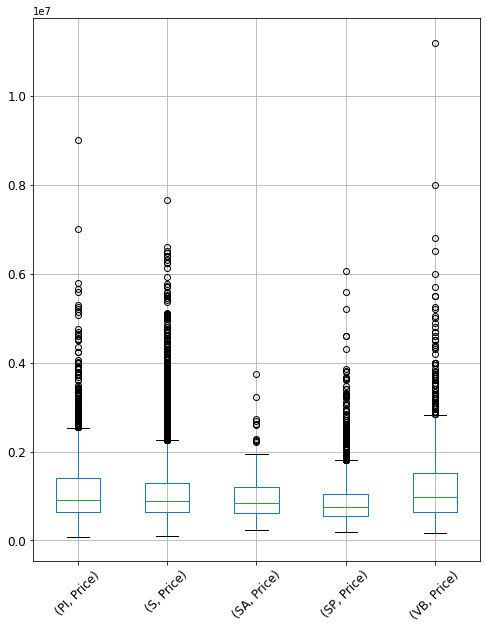

In [12]:
raw_data[['Method','Price']].groupby('Method').boxplot(rot=45, fontsize=12, figsize=(8,10), subplots=False)

In [13]:
type_dummies = pd.get_dummies(raw_data['Type'])
method_dummies = pd.get_dummies(raw_data['Method'])
raw_data = pd.concat([raw_data, type_dummies, method_dummies], axis=1)
raw_data.head()

Suburb           Address  Rooms Type      Price Method  Distance  \
1  Abbotsford      85 Turner St      2    h  1480000.0      S       2.5   
2  Abbotsford   25 Bloomburg St      2    h  1035000.0      S       2.5   
4  Abbotsford      5 Charles St      3    h  1465000.0     SP       2.5   
5  Abbotsford  40 Federation La      3    h   850000.0     PI       2.5   
6  Abbotsford       55a Park St      4    h  1600000.0     VB       2.5   

   Bedroom2  Bathroom  Car  ...  Longtitude  Propertycount  h  t  u  PI  S  \
1       2.0       1.0  1.0  ...    144.9984         4019.0  1  0  0   0  1   
2       2.0       1.0  0.0  ...    144.9934         4019.0  1  0  0   0  1   
4       3.0       2.0  0.0  ...    144.9944         4019.0  1  0  0   0  0   
5       3.0       2.0  1.0  ...    144.9969         4019.0  1  0  0   1  0   
6       3.0       1.0  2.0  ...    144.9941         4019.0  1  0  0   0  0   

   SA  SP  VB  
1   0   0   0  
2   0   0   0  
4   0   1   0  
5   0   0   0  
6   0   0   1  

[5 rows x 25 columns]

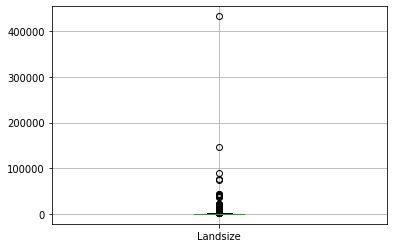

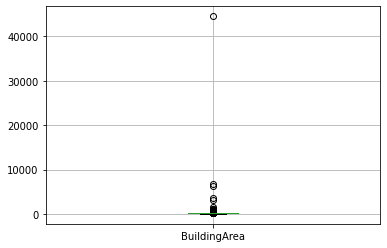

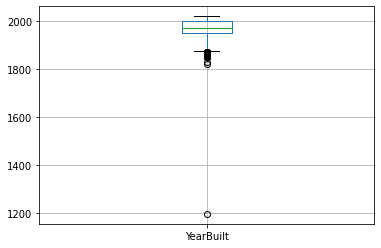

In [14]:
#Check and remove outliers
for column in raw_data[['Landsize','BuildingArea','YearBuilt']]:
    plt.figure()
    raw_data.boxplot([column])

In [15]:
# Remove outliers but keep NaN's
raw_data = raw_data[(raw_data.YearBuilt > 1800) | (pd.isna(raw_data.YearBuilt))]
raw_data = raw_data[(raw_data.BuildingArea < 10000) | (pd.isna(raw_data.BuildingArea))]
raw_data = raw_data[(raw_data.Landsize < 200000) | (pd.isna(raw_data.Landsize))]

In [16]:
#Drop columns
raw_data.drop(columns=['Bedroom2','Propertycount'], inplace=True)

# Checkpoint 2

In [17]:
raw_data.isna().sum()

Suburb              0
Address             0
Rooms               0
Type                0
Price               0
Method              0
Distance            1
Bathroom         6447
Car              6824
Landsize         9265
BuildingArea    16590
YearBuilt       15161
CouncilArea         3
Lattitude        6254
Longtitude       6254
h                   0
t                   0
u                   0
PI                  0
S                   0
SA                  0
SP                  0
VB                  0
dtype: int64

<AxesSubplot:>

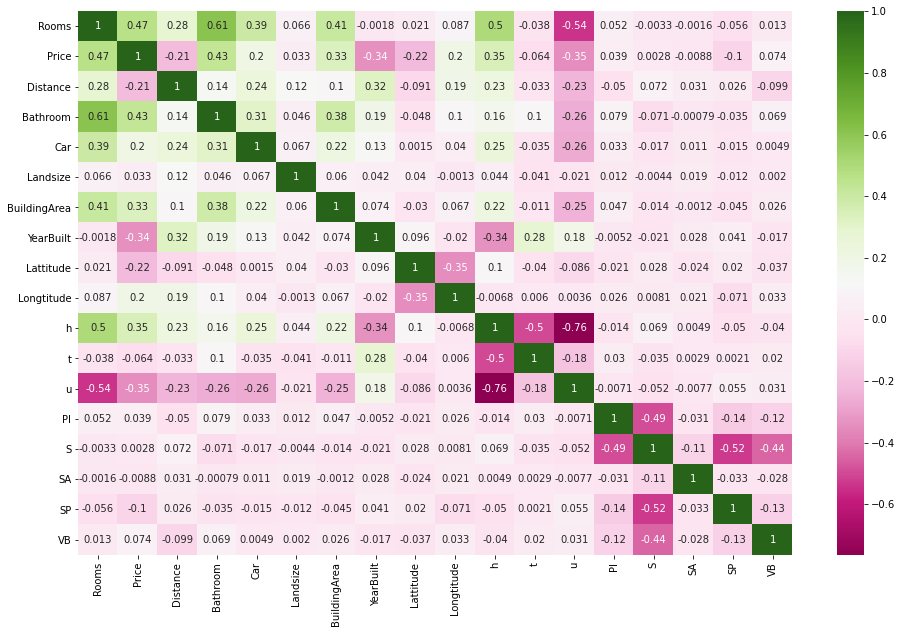

In [18]:
plt.figure(figsize=(16, 10))
sns.heatmap(raw_data.corr(), annot=True, cmap="PiYG")

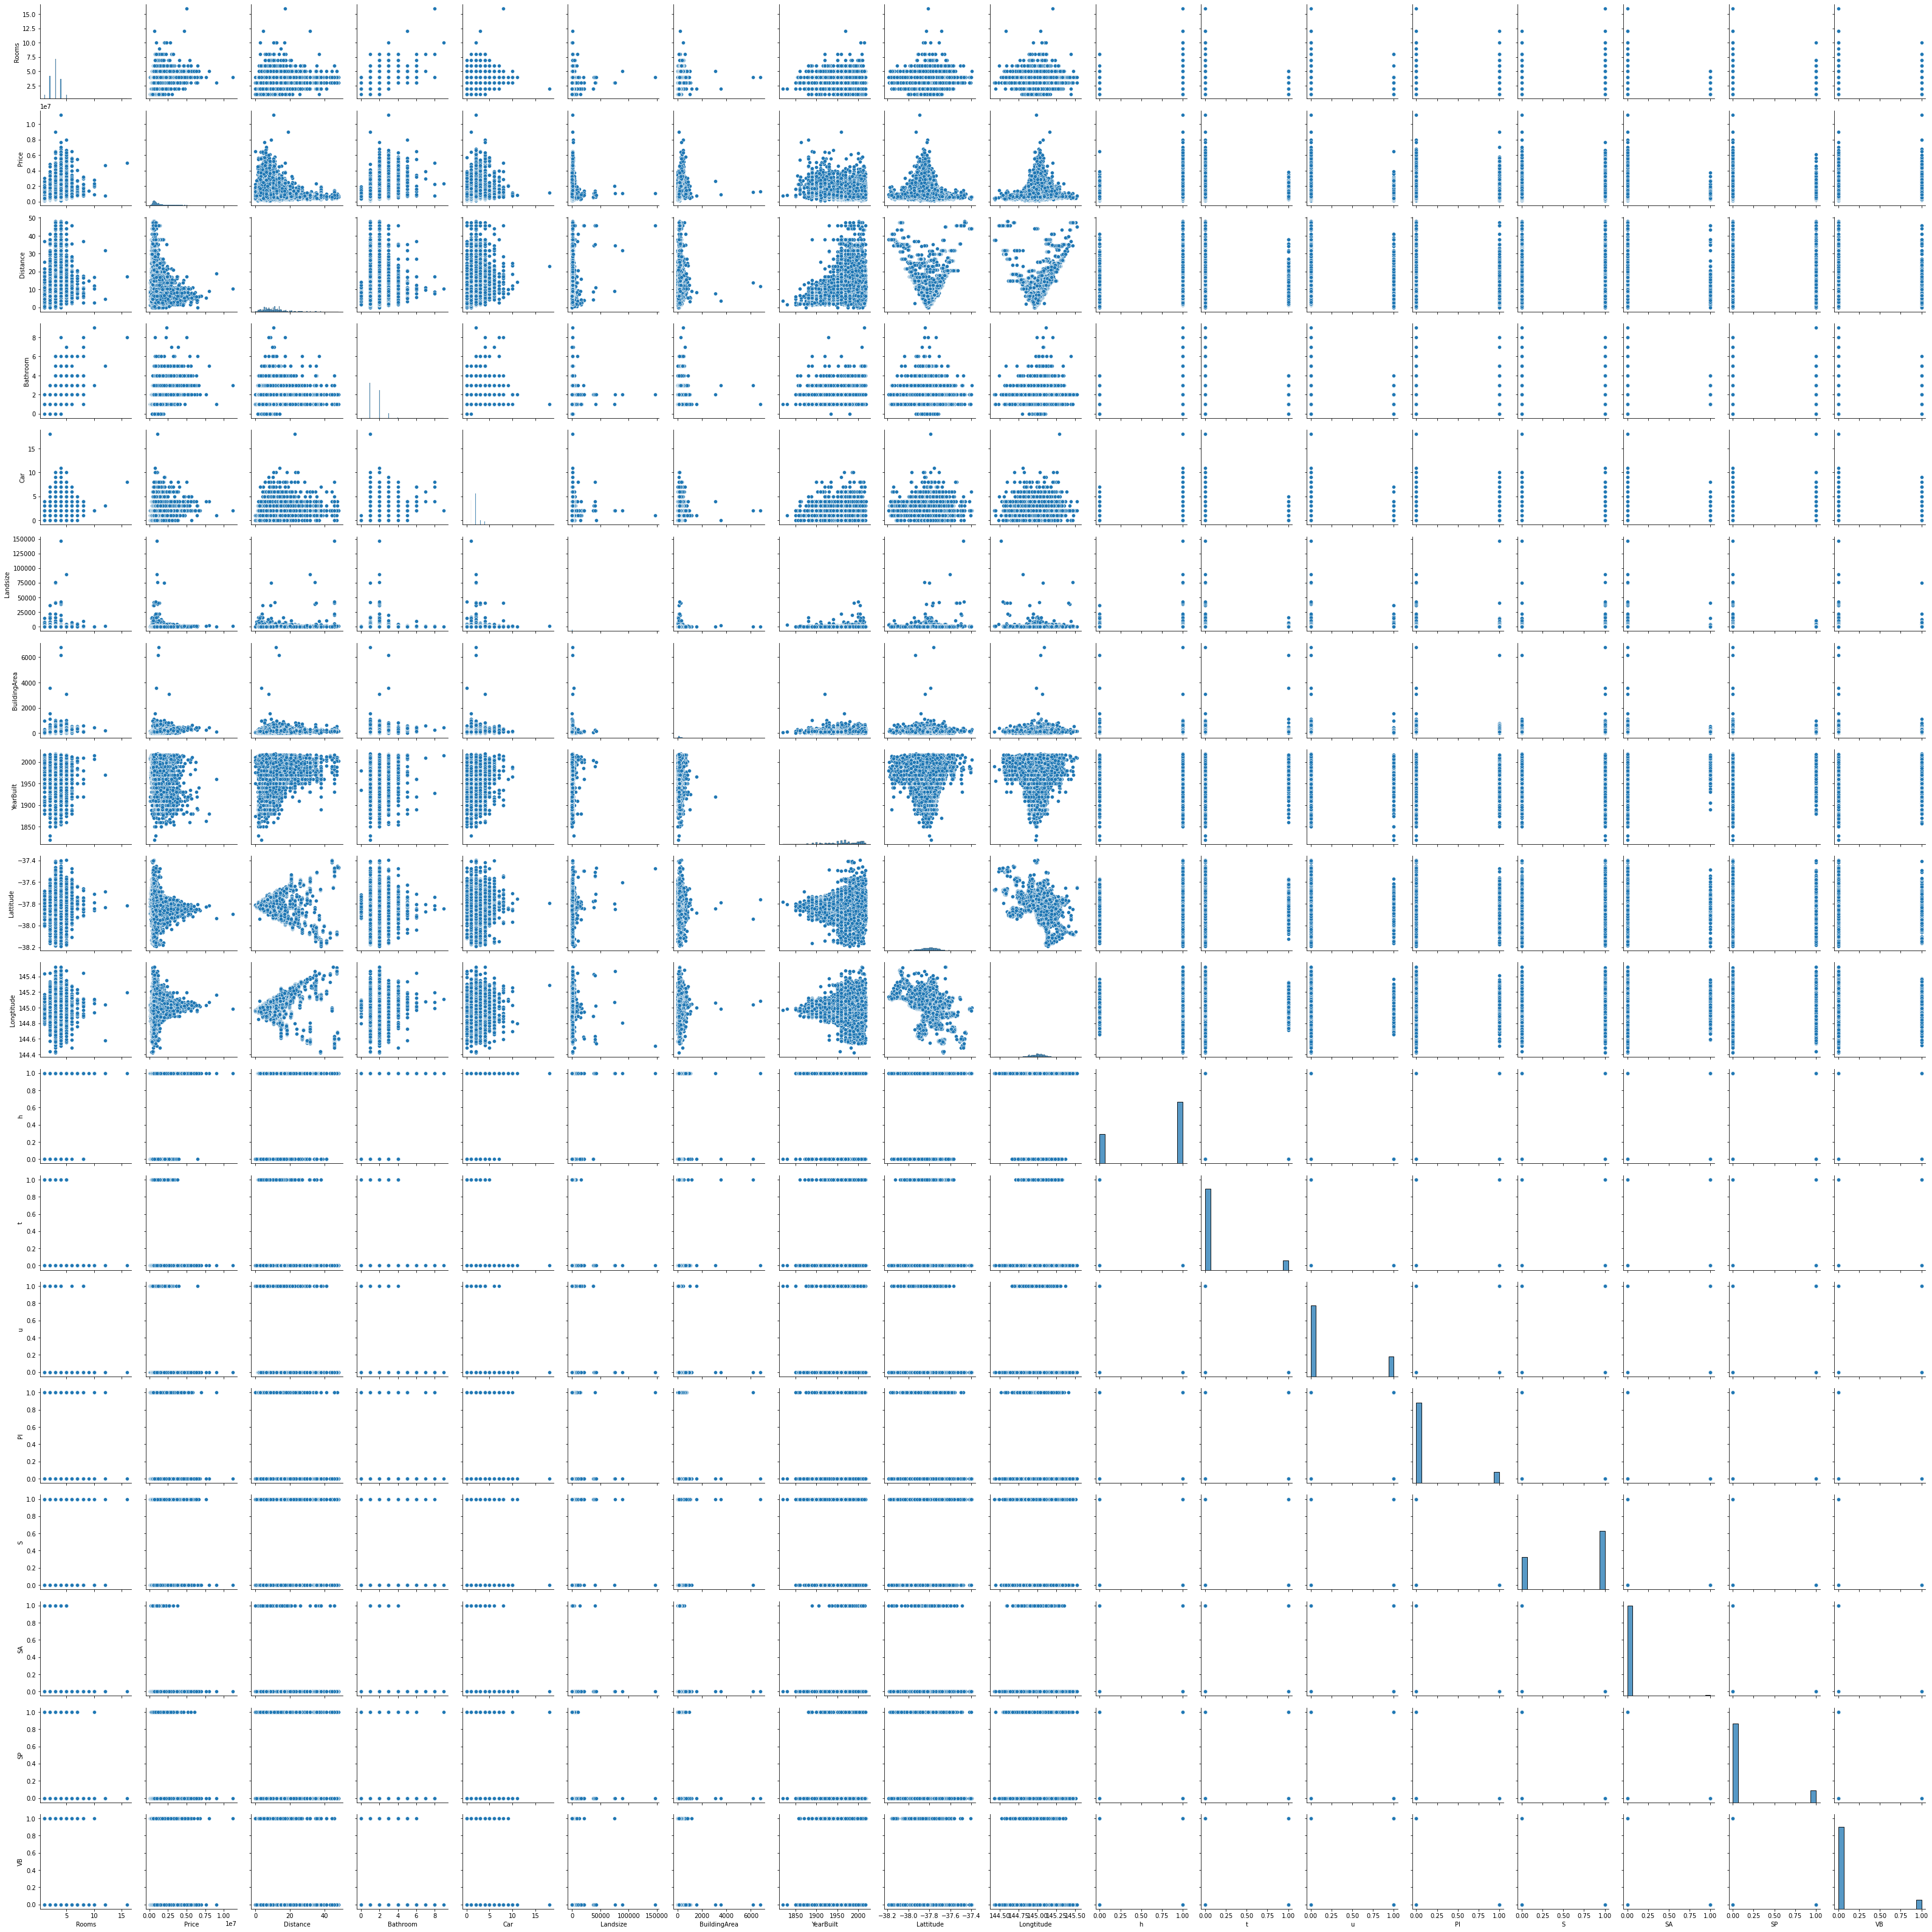

In [19]:
sns.pairplot(raw_data)

In [20]:
#Drop columns
raw_data.drop(columns=['VB','SP','SA','S','PI','Landsize','Method'], inplace=True)

In [21]:
raw_data.isna().sum()

Suburb              0
Address             0
Rooms               0
Type                0
Price               0
Distance            1
Bathroom         6447
Car              6824
BuildingArea    16590
YearBuilt       15161
CouncilArea         3
Lattitude        6254
Longtitude       6254
h                   0
t                   0
u                   0
dtype: int64

In [22]:
temp = raw_data.groupby('Suburb').count()
temp[temp['CouncilArea'] == 0]

Address  Rooms  Type  Price  Distance  Bathroom  Car  \
Suburb                                                              
Fawkner Lot        1      1     1      1         0         0    0   

             BuildingArea  YearBuilt  CouncilArea  Lattitude  Longtitude  h  \
Suburb                                                                        
Fawkner Lot             0          0            0          0           0  1   

             t  u  
Suburb             
Fawkner Lot  1  1

In [23]:
# Drop this record - missing lots of data
raw_data.dropna(subset=['Distance'], inplace=True)

In [24]:
suburb_data = raw_data.drop(columns=
                            ['Address',
                             'Price',
                             'Distance',
                             'Lattitude',
                             'Longtitude',
                             'h','t','u'])

In [25]:
# Round 1
for index, row in raw_data.drop(columns=['Lattitude','Longtitude']).iterrows():
    if row.isna().any():
        temp_suburb = suburb_data[suburb_data['Suburb'] == row['Suburb']]
        temp_type = temp_suburb[temp_suburb['Type'] == row['Type']]
        temp_rooms = temp_type[temp_type['Rooms'] == row['Rooms']]
        
        if pd.isna(row['Bathroom']):
            raw_data.at[index, 'Bathroom'] = temp_rooms[['Bathroom']].median()
            
        if pd.isna(row['Car']):
            raw_data.at[index, 'Car'] = temp_rooms[['Car']].median()

        if pd.isna(row['BuildingArea']):
            raw_data.at[index, 'BuildingArea'] = temp_rooms[['BuildingArea']].median()

        if pd.isna(row['YearBuilt']):
            raw_data.at[index, 'YearBuilt'] = temp_type[['YearBuilt']].median()
            
        if pd.isna(row['CouncilArea']):
            raw_data.at[index, 'CouncilArea'] = temp_suburb[['CouncilArea']].mode()

In [26]:
raw_data.isna().sum()

Suburb             0
Address            0
Rooms              0
Type               0
Price              0
Distance           0
Bathroom         465
Car              471
BuildingArea    1195
YearBuilt        321
CouncilArea        0
Lattitude       6253
Longtitude      6253
h                  0
t                  0
u                  0
dtype: int64

In [27]:
# Round 2
for index, row in raw_data.drop(columns=['Lattitude','Longtitude']).iterrows():
    if row.isna().any():
        temp_council = suburb_data[suburb_data['CouncilArea'] == row['CouncilArea']]
        temp_type = temp_suburb[temp_suburb['Type'] == row['Type']]
        temp_rooms = temp_type[temp_type['Rooms'] == row['Rooms']]
        
        if pd.isna(row['Bathroom']):
            raw_data.at[index, 'Bathroom'] = temp_rooms[['Bathroom']].median()
            
        if pd.isna(row['Car']):
            raw_data.at[index, 'Car'] = temp_rooms[['Car']].median()
            
        if pd.isna(row['BuildingArea']):
            raw_data.at[index, 'BuildingArea'] = temp_rooms[['BuildingArea']].median()

        if pd.isna(row['YearBuilt']):
            raw_data.at[index, 'YearBuilt'] = temp_type[['YearBuilt']].median()

In [28]:
raw_data.isna().sum()

Suburb             0
Address            0
Rooms              0
Type               0
Price              0
Distance           0
Bathroom         162
Car              164
BuildingArea     326
YearBuilt          0
CouncilArea        0
Lattitude       6253
Longtitude      6253
h                  0
t                  0
u                  0
dtype: int64

In [29]:
# Round 3
for index, row in raw_data.drop(columns=['Lattitude','Longtitude']).iterrows():
    if row.isna().any():
        temp_suburb = suburb_data[suburb_data['Suburb'] == row['Suburb']]
        
        if pd.isna(row['Bathroom']):
            raw_data.at[index, 'Bathroom'] = suburb_data[['Bathroom']].median()
            
        if pd.isna(row['Car']):
            raw_data.at[index, 'Car'] = suburb_data[['Car']].median()
            
        if pd.isna(row['BuildingArea']):
            raw_data.at[index, 'BuildingArea'] = suburb_data[['BuildingArea']].median()

In [30]:
raw_data.isna().sum()

Suburb             0
Address            0
Rooms              0
Type               0
Price              0
Distance           0
Bathroom           0
Car                0
BuildingArea       0
YearBuilt          0
CouncilArea        0
Lattitude       6253
Longtitude      6253
h                  0
t                  0
u                  0
dtype: int64

# Checkpoint 3

### Get geolocation

In [31]:
# geolocator = Nominatim(user_agent="my_request")
# geocode = RateLimiter(lambda query: geolocator.geocode("%s, Melbourne Australia" % query), min_delay_seconds=1)

In [32]:
raw_data['Add+Sub'] = raw_data['Address'] + ', ' + raw_data['Suburb']
raw_data[raw_data['Add+Sub'].duplicated(keep=False)].sort_values(by='Address')

Suburb          Address  Rooms Type      Price  Distance  \
15221        Preston   1 Bellarine St      5    h  1400000.0       8.4   
8221         Preston   1 Bellarine St      4    h  1400000.0       8.8   
14969       Essendon       1 Daisy St      4    h  1360000.0       7.5   
12720       Essendon       1 Daisy St      4    h  1400000.0       8.0   
12055       Seaholme    1 Seaholme Av      5    h   950000.0      12.7   
...              ...              ...    ...  ...        ...       ...   
16057     Ascot Vale  97 The Crescent      3    h  1100000.0       4.3   
27428  Wheelers Hill  982 Waverley Rd      4    h  1150000.0      16.7   
31418  Wheelers Hill  982 Waverley Rd      4    h  1077000.0      16.7   
11157        Carlton      99 Neill St      3    h  1550000.0       1.8   
11149        Carlton      99 Neill St      3    h  1600000.0       1.8   

       Bathroom  Car  BuildingArea  YearBuilt                 CouncilArea  \
15221       2.0  2.0         217.0     1925.0        Darebin City Council   
8221        2.0  2.0         217.0     1925.0        Darebin City Council   
14969       2.0  1.0         217.5     1950.0  Moonee Valley City Council   
12720       2.0  1.0         217.5     1950.0  Moonee Valley City Council   
12055       3.0  5.0         313.0     2005.0    Hobsons Bay City Council   
...         ...  ...           ...        ...                         ...   
16057       2.0  2.0         134.0     1920.0  Moonee Valley City Council   
27428       2.0  2.0         181.5     1980.0         Monash City Council   
31418       2.0  2.0         181.5     1980.0         Monash City Council   
11157       3.0  1.0         192.0     1890.0      Melbourne City Council   
11149       3.0  1.0         192.0     1890.0      Melbourne City Council   

       Lattitude  Longtitude  h  t  u                         Add+Sub  
15221  -37.73472   144.99658  1  0  0         1 Bellarine St, Preston  
8221   -37.73470   144.99660  1  0  0         1 Bellarine St, Preston  
14969  -37.75472   144.92723  1  0  0            1 Daisy St, Essendon  
12720  -37.75580   144.91060  1  0  0            1 Daisy St, Essendon  
12055        NaN         NaN  1  0  0         1 Seaholme Av, Seaholme  
...          ...         ... .. .. ..                             ...  
16057  -37.77263   144.92045  1  0  0     97 The Crescent, Ascot Vale  
27428  -37.89190   145.18990  1  0  0  982 Waverley Rd, Wheelers Hill  
31418  -37.89194   145.18994  1  0  0  982 Waverley Rd, Wheelers Hill  
11157  -37.79450   144.97180  1  0  0            99 Neill St, Carlton  
11149  -37.79450   144.97180  1  0  0            99 Neill St, Carlton  

[558 rows x 17 columns]

In [33]:
# temp = raw_data[pd.isna(raw_data['Lattitude'])]
# temp = temp[['Lattitude','Longtitude','Add+Sub']].drop_duplicates()
# temp.head()

In [34]:
# temp['location'] = temp['Add+Sub'].apply(geocode)
# temp['Lattitude'] = temp['location'].apply(lambda x: x.latitude if x else None)
# temp['Longtitude'] = temp['location'].apply(lambda x: x.longitude if x else None)
# temp.to_csv('temp.csv')
temp = pd.read_csv('temp.csv')

In [35]:
# for index, row in raw_data[pd.isna(raw_data['Lattitude'])].iterrows():
#     if pd.isna(row['Lattitude']):
#         for index2, row2 in temp.iterrows():
#             if row['Add+Sub'] == row2['Add+Sub']:
#                 raw_data.at[index, 'Lattitude'] = row2['Lattitude']
#                 raw_data.at[index, 'Longtitude'] = row2['Longtitude']
#                 break
filled_data = raw_data.merge(temp,
                          left_on='Add+Sub', right_on='Add+Sub',
                          how='left',
                          suffixes=('','_new'))
filled_data['Lattitude'].fillna(filled_data['Lattitude_new'], inplace=True)
filled_data['Longtitude'].fillna(filled_data['Longtitude_new'], inplace=True)
filled_data[['Lattitude','Lattitude_new']]

Lattitude  Lattitude_new
0     -37.799600            NaN
1     -37.807900            NaN
2     -37.809300            NaN
3     -37.796900            NaN
4     -37.807200            NaN
...          ...            ...
27238 -37.810530            NaN
27239 -37.815510            NaN
27240 -37.822860            NaN
27241 -37.815652     -37.815652
27242 -37.818100            NaN

[27243 rows x 2 columns]

In [36]:
#Remove any locations not found
filled_data.dropna(subset=['Lattitude'], inplace=True)

In [37]:
filled_data.isna().sum()

Suburb                0
Address               0
Rooms                 0
Type                  0
Price                 0
Distance              0
Bathroom              0
Car                   0
BuildingArea          0
YearBuilt             0
CouncilArea           0
Lattitude             0
Longtitude            0
h                     0
t                     0
u                     0
Add+Sub               0
ID                20950
Lattitude_new     20951
Longtitude_new    20951
location          20951
dtype: int64

In [38]:
filled_data.drop(columns=['Lattitude_new',
                          'Longtitude_new',
                          'Add+Sub',
                          'location',
                          'ID',
                          'Suburb',
                          'Address',
                          'Type',
                          'CouncilArea',
                          't'],
                 inplace=True)

In [39]:
filled_data.head()

Rooms      Price  Distance  Bathroom  Car  BuildingArea  YearBuilt  \
0      2  1480000.0       2.5       1.0  1.0          91.5     1900.0   
1      2  1035000.0       2.5       1.0  0.0          79.0     1900.0   
2      3  1465000.0       2.5       2.0  0.0         150.0     1900.0   
3      3   850000.0       2.5       2.0  1.0         114.0     1900.0   
4      4  1600000.0       2.5       1.0  2.0         142.0     2014.0   

   Lattitude  Longtitude  h  u  
0   -37.7996    144.9984  1  0  
1   -37.8079    144.9934  1  0  
2   -37.8093    144.9944  1  0  
3   -37.7969    144.9969  1  0  
4   -37.8072    144.9941  1  0

### setup models

In [183]:
dataset = filled_data
X = dataset.drop(columns=['Price'])
y = dataset['Price']

In [184]:
cv = ShuffleSplit(n_splits = 10, test_size = 0.10)
train_size = np.linspace(.1, 1.0, 15)
test_size = .25

In [185]:
def LearningCurve(X, y, model, cv, train_sizes):

    train_sizes, train_scores, test_scores = learning_curve(model, X, y, cv = cv, n_jobs = -1, 
                                                            train_sizes = train_sizes)

    train_scores_mean = np.mean(train_scores, axis = 1)
    train_scores_std  = np.std(train_scores, axis = 1)
    test_scores_mean  = np.mean(test_scores, axis = 1)
    test_scores_std   = np.std(test_scores, axis = 1)
    
    train_Error_mean = np.mean(1- train_scores, axis = 1)
    train_Error_std  = np.std(1 - train_scores, axis = 1)
    test_Error_mean  = np.mean(1 - test_scores, axis = 1)
    test_Error_std   = np.std(1 - test_scores, axis = 1)

    Scores_mean = np.mean(train_scores_mean)
    Scores_std = np.mean(train_scores_std)
    
    _, y_test, y_pred, Time = ApplyModel(X, y, model)
    
    Accuracy = round(np.median(cross_val_score(model, X, y, cv = cv)),2)*100
    
    plt.figure(figsize = (16,6))
    plt.subplot(1,2,1)
    for i in range(cv.n_splits):
        _, y_test, y_pred, tim = ApplyModel(X, y, model)
        plt.scatter(y_test, y_pred,s=5,alpha=.1)
    axes = plt.gca()
    plt.xlim(0,
             max(axes.get_ylim()[1], axes.get_xlim()[1]))
    plt.ylim(axes.get_xlim())
    plt.plot(axes.get_xlim(),axes.get_ylim(), 'r--')
    plt.subplot(1,2,2)
    plt.fill_between(train_sizes, train_Error_mean - train_Error_std,train_Error_mean + train_Error_std, alpha = 0.1,
                     color = "r")
    plt.fill_between(train_sizes, test_Error_mean - test_Error_std, test_Error_mean + test_Error_std, alpha = 0.1, color = "g")
    plt.plot(train_sizes, train_Error_mean, 'o-', color = "r",label = "Training Error")
    plt.plot(train_sizes, test_Error_mean, 'o-', color = "g",label = "Cross-validation Error")
    plt.legend(loc = "best")
    plt.grid(True)
     
    return (model, Scores_mean, Scores_std, Accuracy, Time)

def ApplyModel(X, y, model):

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    
    Time = time.perf_counter()
    
    model.fit(X_train, y_train)
    y_pred  = model.predict(X_test)
    
    return (model, y_test, y_pred, time.perf_counter() - Time)  

def PrintResults(model, X, y, title):
    
    start_time = time.perf_counter()
        
    _, Score_mean, Score_std, Accuracy, Time = LearningCurve(X, y, model, cv, train_size)
    Score_mean, Score_std = Score_mean*100, Score_std*100
    
    print('Model Time: %.2f s'%(Time))
    print('Total Time: %.2f s'%(time.perf_counter() - start_time))
    print('Scoring Accuracy: %.2f %%'%(Accuracy))
    print('Scoring Mean: %.2f %%'%(Score_mean))
    print('Scoring Standard Deviation: %.4f %%'%(Score_std))
    
    Summary = pd.DataFrame({'Model': title,
                       'Accuracy': Accuracy, 
                       'Score Mean': Score_mean, 
                       'Score St Dv': Score_std}, index = [0])
    return (model, Summary)

In [186]:
forest_reg = RandomForestRegressor(n_jobs=-1, n_estimators=10)
linear_reg = LinearRegression(n_jobs=-1)

In [187]:
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import learning_curve

### First run

Model Time: 0.29 s
Total Time: 30.35 s
Scoring Accuracy: 75.00 %
Scoring Mean: 95.02 %
Scoring Standard Deviation: 0.2658 %


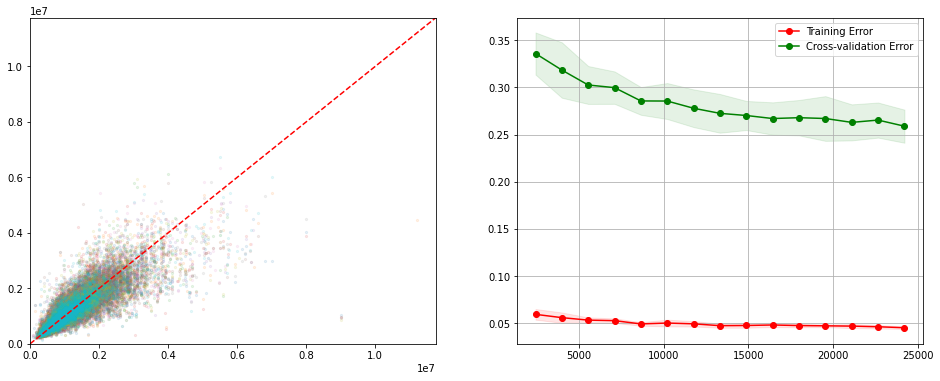

In [188]:
forest_reg, Summary_FR = PrintResults(forest_reg, X, y, 'Random Forest')

Model Time: 0.02 s
Total Time: 1.62 s
Scoring Accuracy: 55.00 %
Scoring Mean: 56.02 %
Scoring Standard Deviation: 0.8747 %


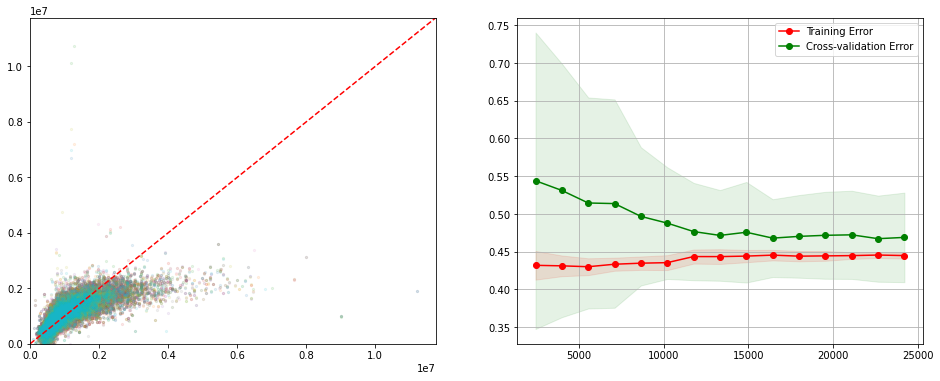

In [189]:
linear_reg, Summary_LR = PrintResults(linear_reg,
                                      X,
                                      y,
                                      'Linear Regression')

# Checkpoint 4

In [190]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

In [191]:
X_scaled = MinMaxScaler().fit_transform(X)


### K Best

Model Time: 0.04 s
Total Time: 3.14 s
Scoring Accuracy: 12.00 %
Scoring Mean: 11.98 %
Scoring Standard Deviation: 0.2854 %
Model Time: 0.00 s
Total Time: 0.68 s
Scoring Accuracy: 12.00 %
Scoring Mean: 11.86 %
Scoring Standard Deviation: 0.3365 %
Model Time: 0.03 s
Total Time: 2.94 s
Scoring Accuracy: 14.00 %
Scoring Mean: 13.70 %
Scoring Standard Deviation: 0.4124 %
Model Time: 0.00 s
Total Time: 0.75 s
Scoring Accuracy: 14.00 %
Scoring Mean: 13.64 %
Scoring Standard Deviation: 0.4732 %
Model Time: 0.05 s
Total Time: 4.90 s
Scoring Accuracy: 46.00 %
Scoring Mean: 47.09 %
Scoring Standard Deviation: 0.9692 %
Model Time: 0.00 s
Total Time: 0.86 s
Scoring Accuracy: 24.00 %
Scoring Mean: 23.42 %
Scoring Standard Deviation: 0.5880 %
Model Time: 0.06 s
Total Time: 6.11 s
Scoring Accuracy: 56.00 %
Scoring Mean: 64.70 %
Scoring Standard Deviation: 1.1077 %
Model Time: 0.00 s
Total Time: 1.02 s
Scoring Accuracy: 38.00 %
Scoring Mean: 37.31 %
Scoring Standard Deviation: 0.8396 %
Model Time: 0.12

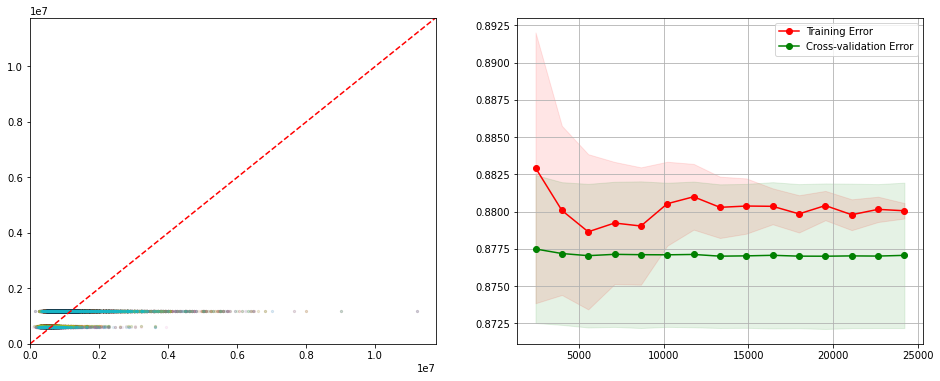

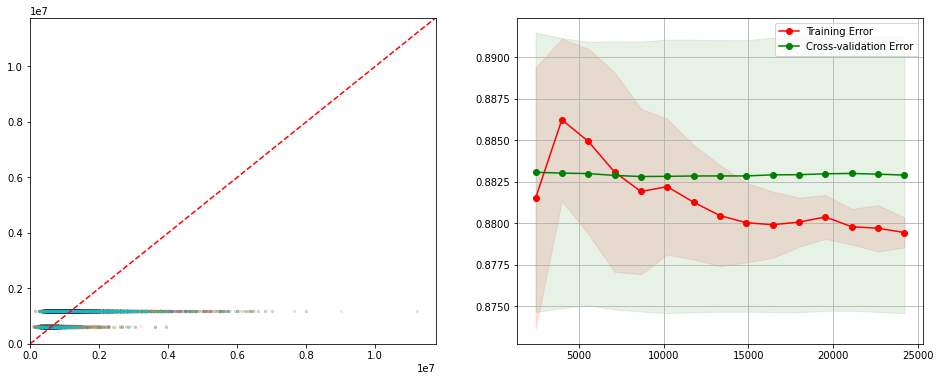

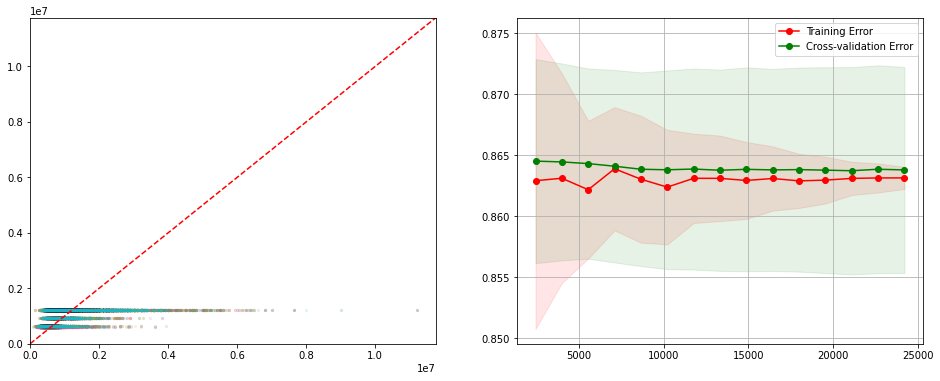

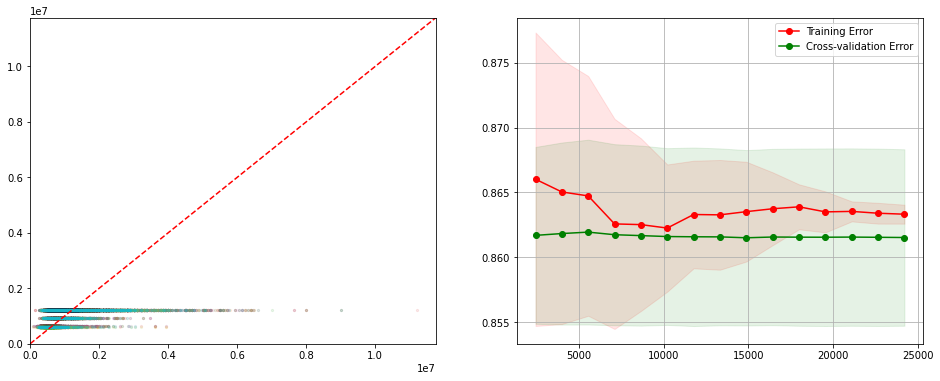

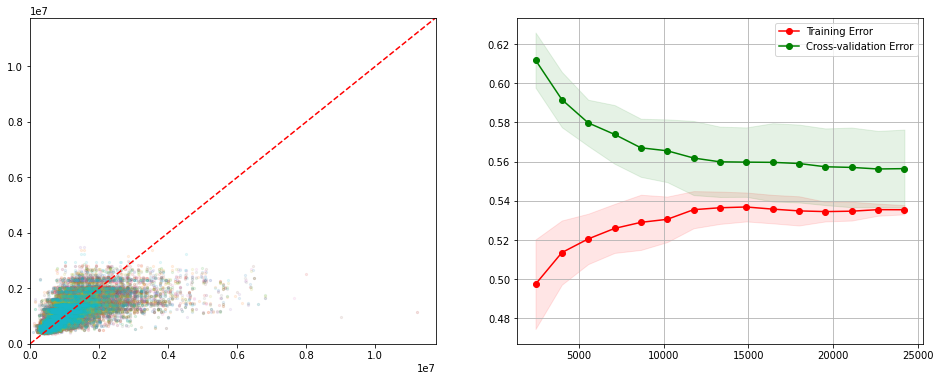

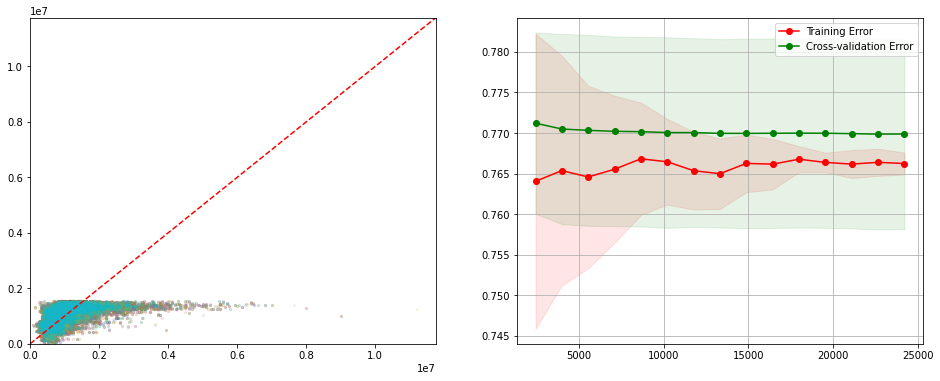

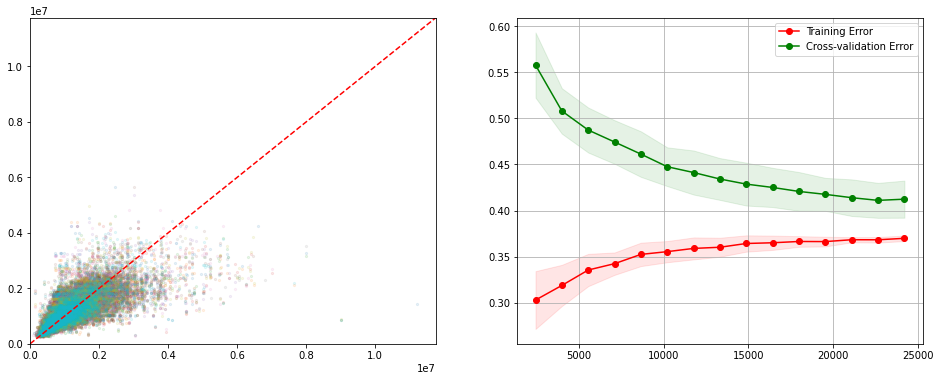

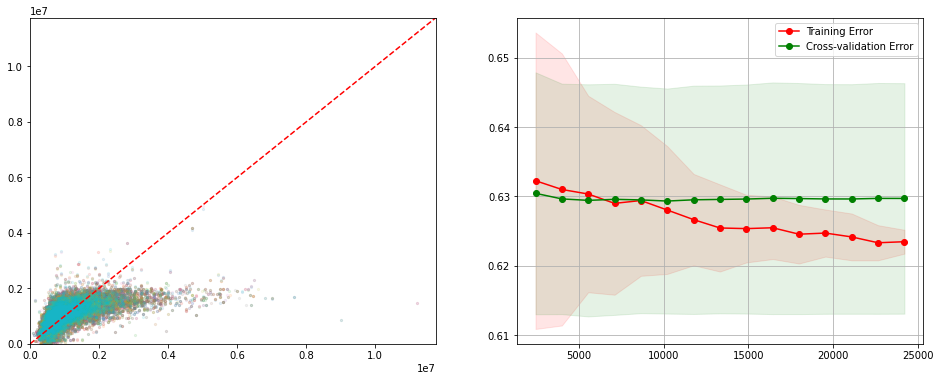

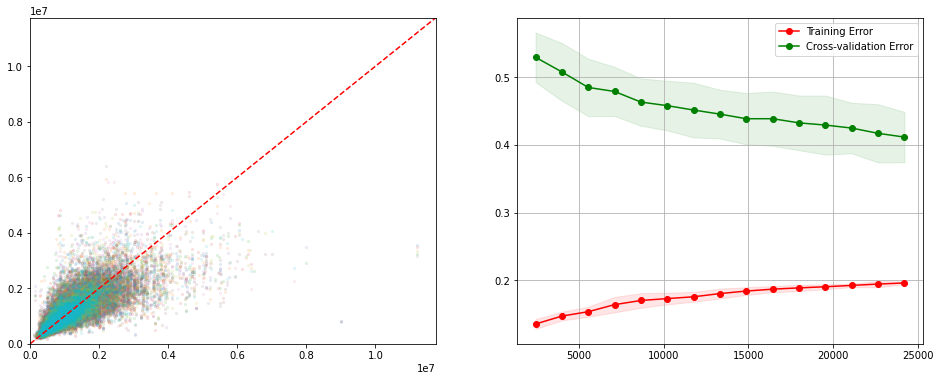

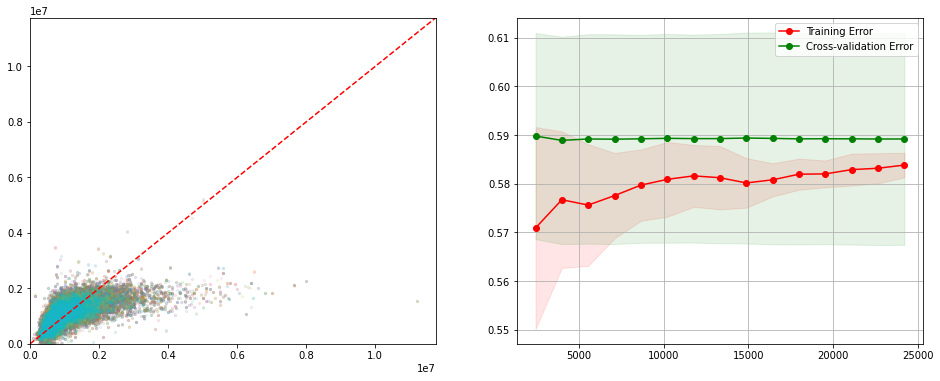

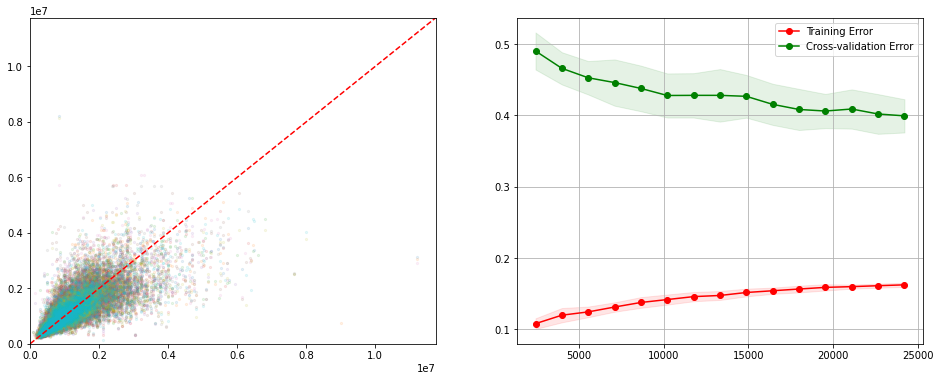

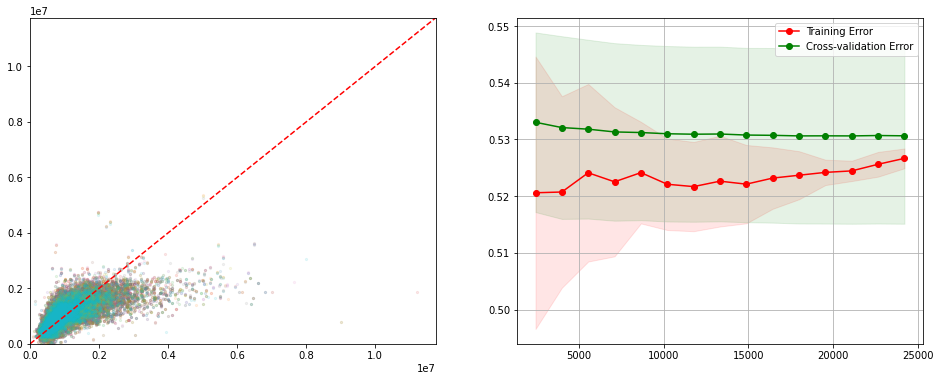

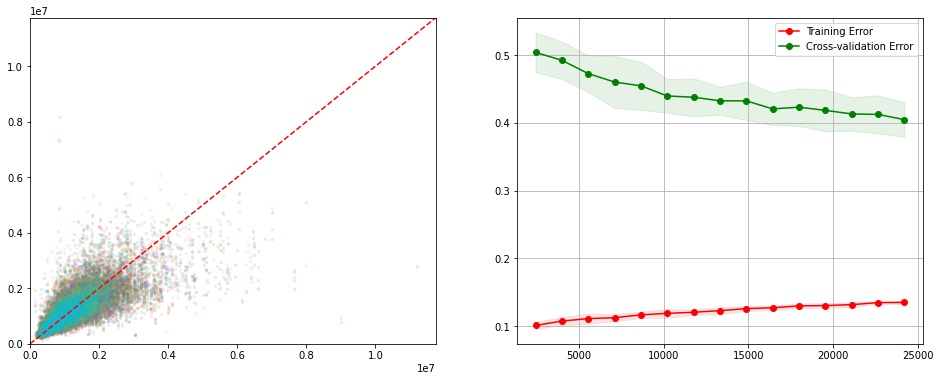

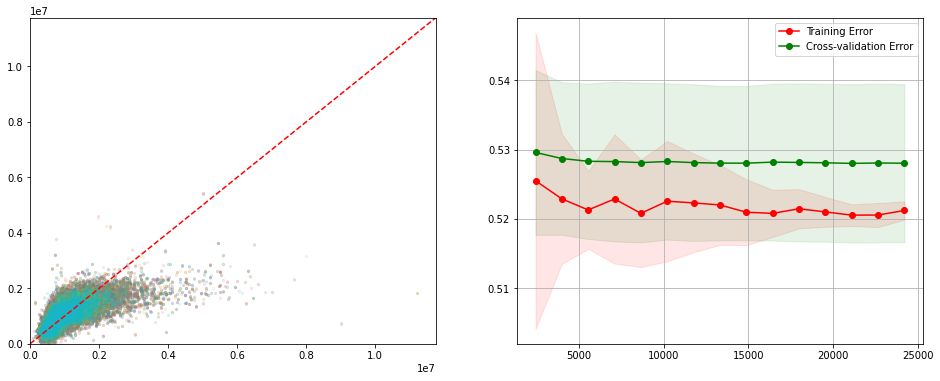

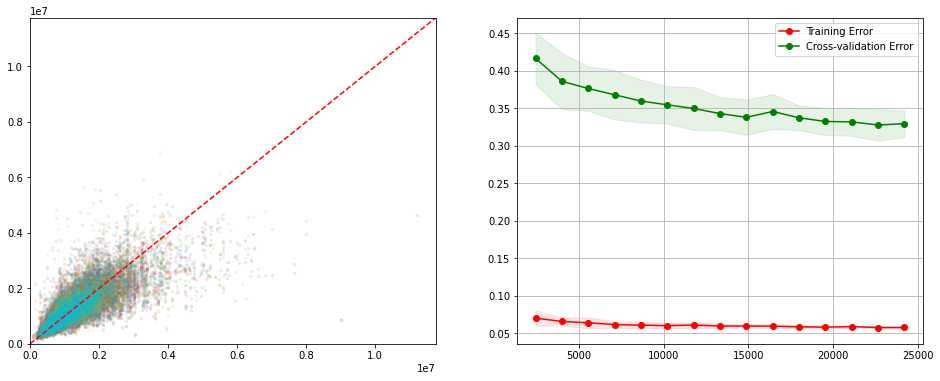

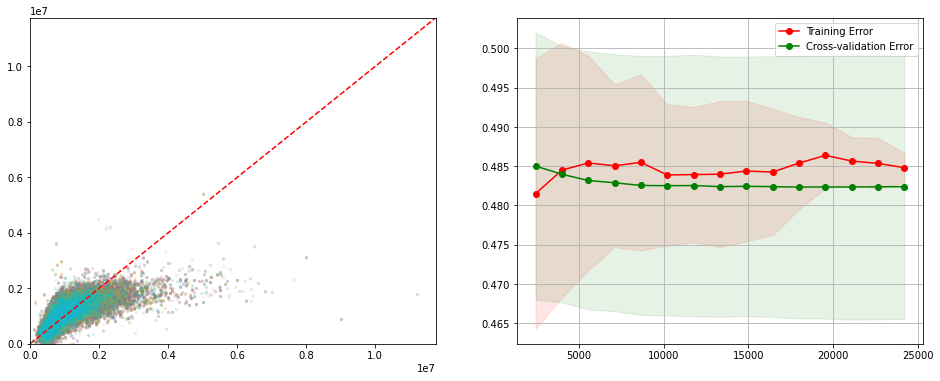

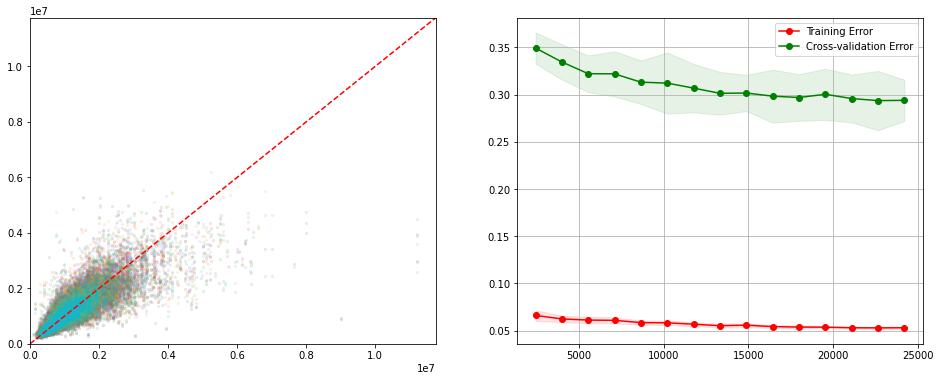

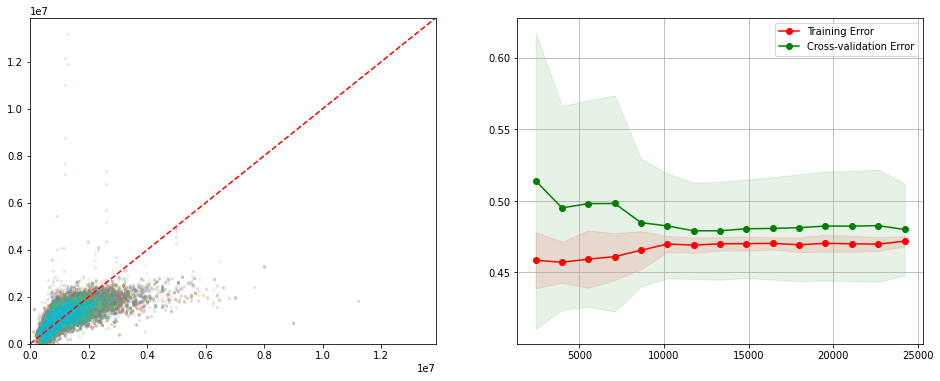

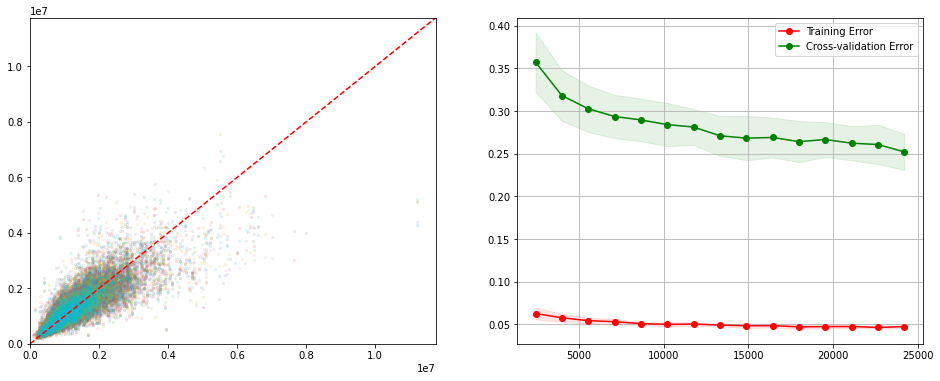

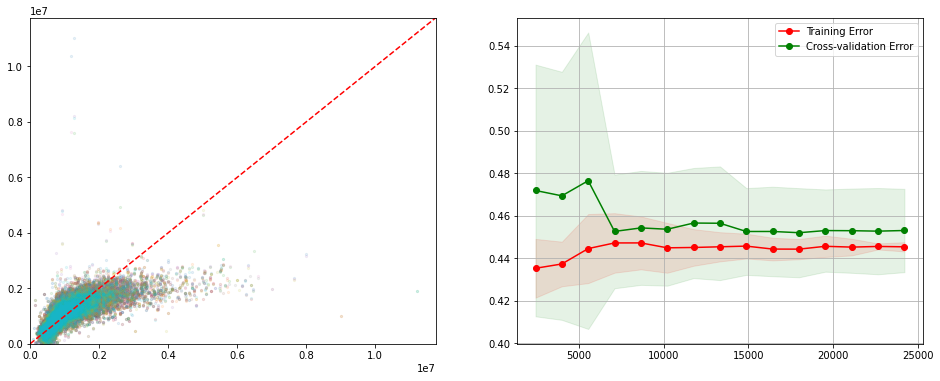

In [192]:
for_acc = pd.DataFrame()
lin_acc = pd.DataFrame()
for x in range(1, len(X.columns) + 1):
    X_best = SelectKBest(chi2, k=x).fit_transform(X_scaled, y)
    forest_reg, Summary_FR = PrintResults(forest_reg,
                                      X_best,
                                      y,
                                      'Random Forest')
    linear_reg, Summary_LR = PrintResults(linear_reg,
                                      X_best,
                                      y,
                                      'Linear Regression')
    for_acc = for_acc.append(Summary_FR)
    lin_acc = lin_acc.append(Summary_LR)

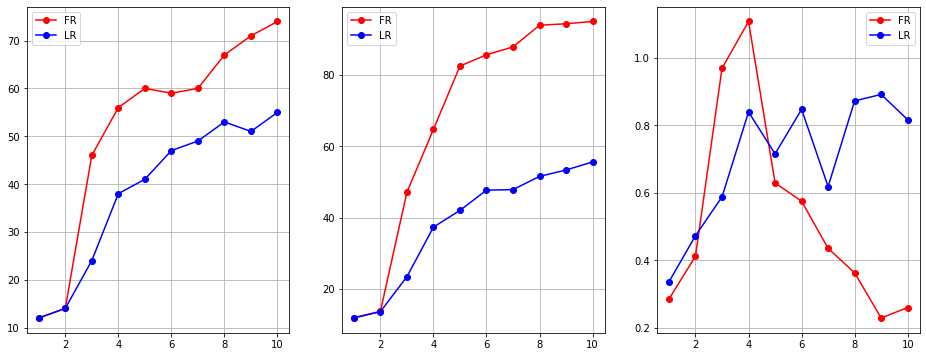

In [193]:
plt.figure(figsize = (16,6))
plt.subplot(1,3,1)
plt.plot([*range(1, len(X.columns)+1)], for_acc.Accuracy, 'o-', color = "r",label = "FR")
plt.plot([*range(1, len(X.columns)+1)], lin_acc.Accuracy, 'o-', color = "b",label = "LR")
plt.legend(loc = "best")
plt.grid(True)
plt.subplot(1,3,2)
plt.plot([*range(1, len(X.columns)+1)], for_acc['Score Mean'], 'o-', color = "r",label = "FR")
plt.plot([*range(1, len(X.columns)+1)], lin_acc['Score Mean'], 'o-', color = "b",label = "LR")
plt.legend(loc = "best")
plt.grid(True)
plt.subplot(1,3,3)
plt.plot([*range(1, len(X.columns)+1)], for_acc['Score St Dv'], 'o-', color = "r",label = "FR")
plt.plot([*range(1, len(X.columns)+1)], lin_acc['Score St Dv'], 'o-', color = "b",label = "LR")
plt.legend(loc = "best")
plt.grid(True)

### Polynomial

In [197]:
poly_feat = PolynomialFeatures(degree=2)
poly_reg = LinearRegression(n_jobs=-1)

Model Time: 0.00 s
Total Time: 3.64 s
Scoring Accuracy: 12.00 %
Scoring Mean: 11.80 %
Scoring Standard Deviation: 0.3185 %
Model Time: 0.01 s
Total Time: 1.07 s
Scoring Accuracy: 14.00 %
Scoring Mean: 13.59 %
Scoring Standard Deviation: 0.2653 %
Model Time: 0.01 s
Total Time: 1.19 s
Scoring Accuracy: 26.00 %
Scoring Mean: 26.25 %
Scoring Standard Deviation: 0.6926 %
Model Time: 0.02 s
Total Time: 1.39 s
Scoring Accuracy: 44.00 %
Scoring Mean: 43.14 %
Scoring Standard Deviation: 0.9824 %
Model Time: 0.02 s
Total Time: 1.79 s
Scoring Accuracy: 45.00 %
Scoring Mean: 45.35 %
Scoring Standard Deviation: 0.7660 %
Model Time: 0.02 s
Total Time: 2.44 s
Scoring Accuracy: 53.00 %
Scoring Mean: 51.90 %
Scoring Standard Deviation: 1.1718 %
Model Time: 0.03 s
Total Time: 3.40 s
Scoring Accuracy: 53.00 %
Scoring Mean: 53.04 %
Scoring Standard Deviation: 0.9880 %
Model Time: 0.05 s
Total Time: 4.74 s
Scoring Accuracy: 58.00 %
Scoring Mean: 59.18 %
Scoring Standard Deviation: 0.7353 %
Model Time: 0.08

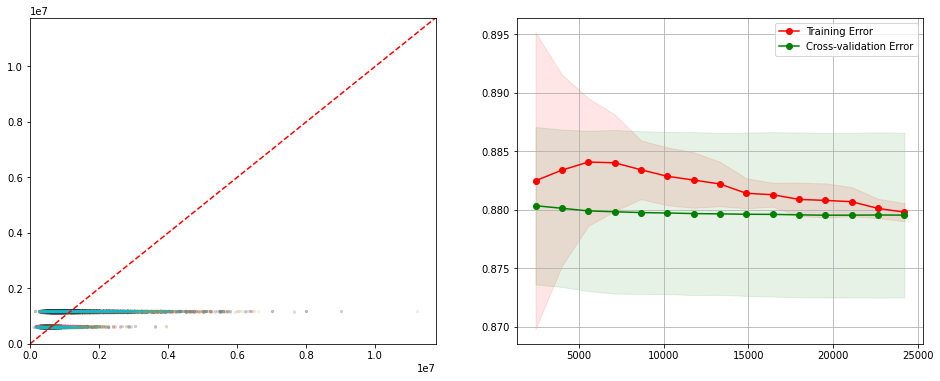

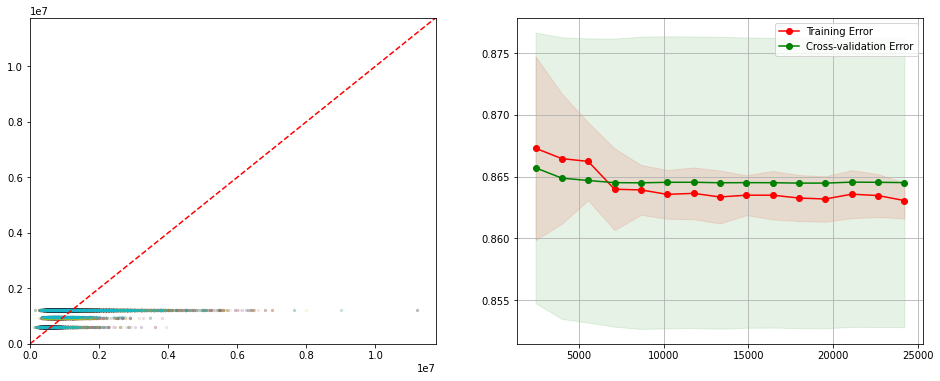

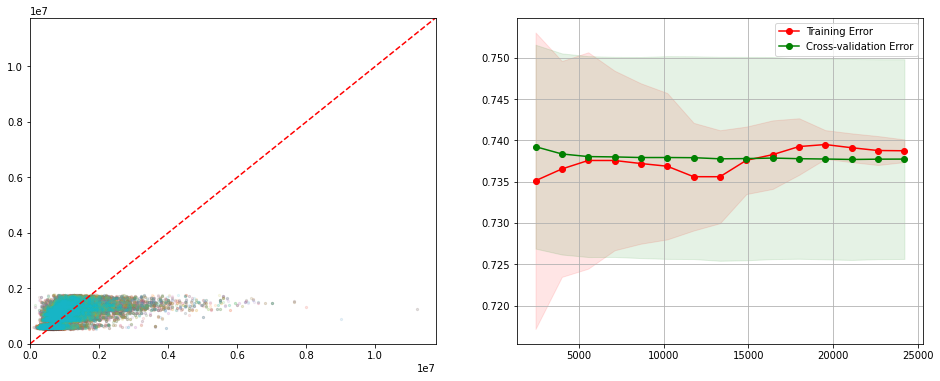

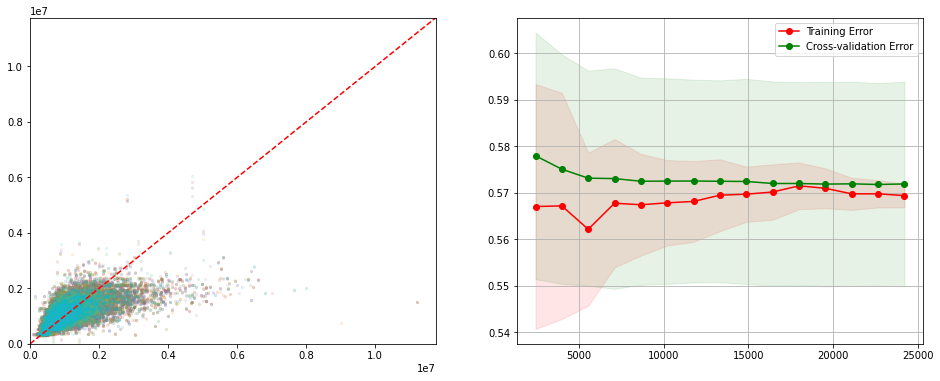

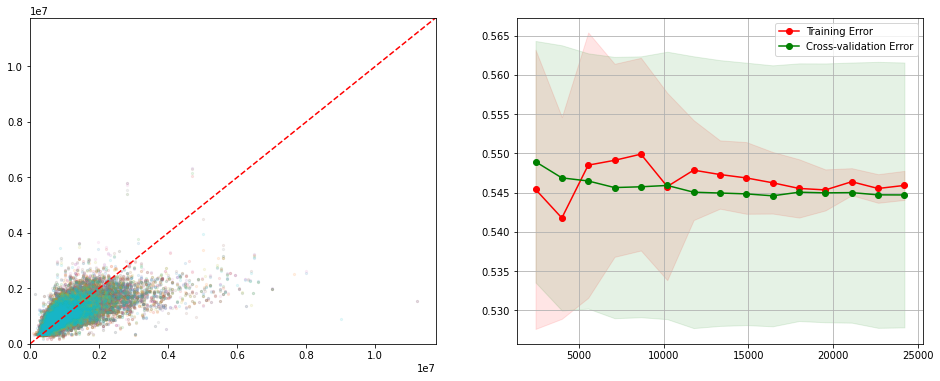

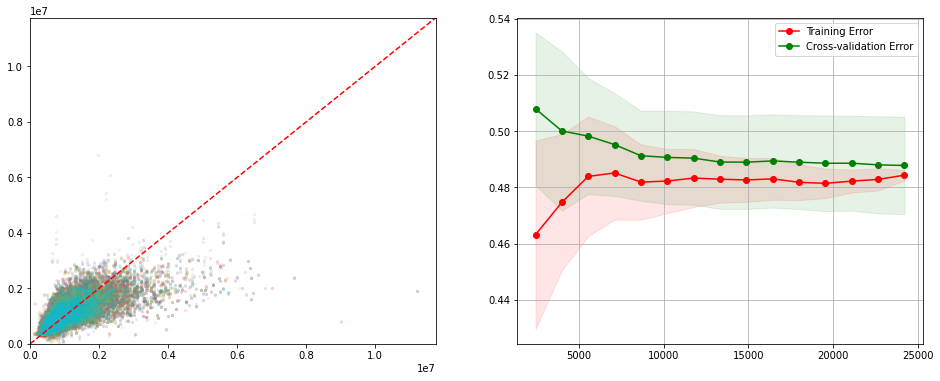

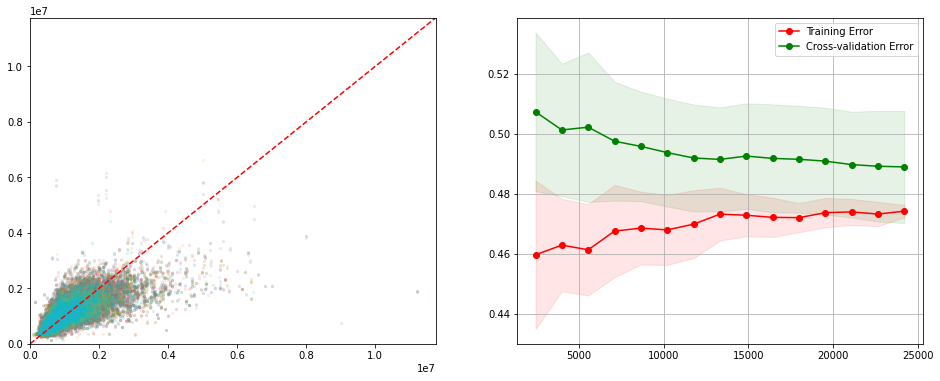

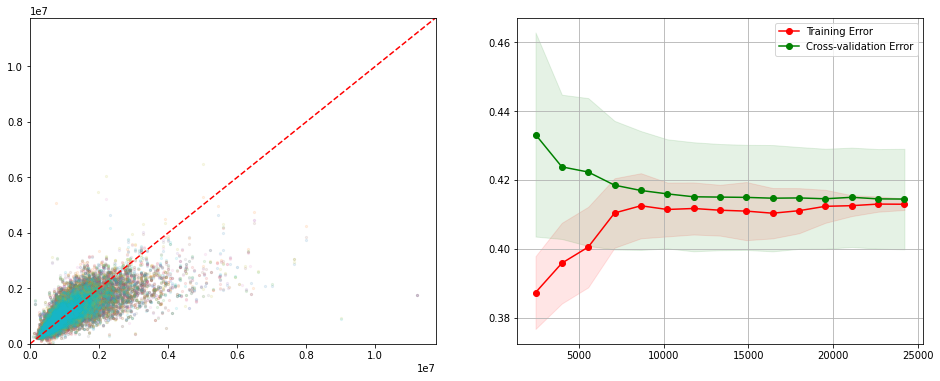

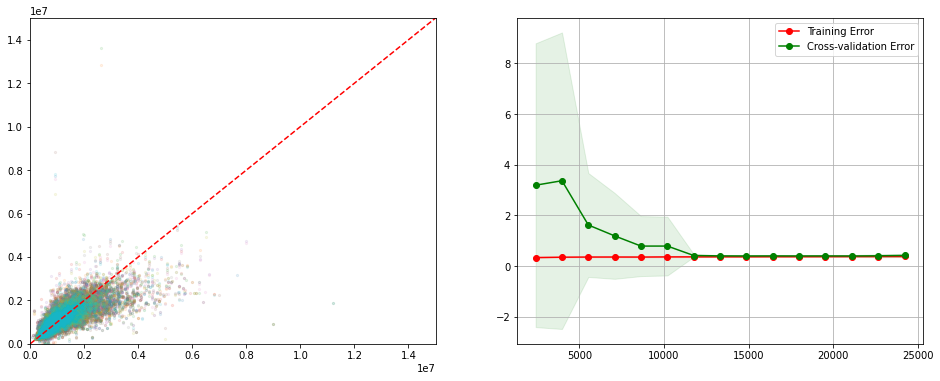

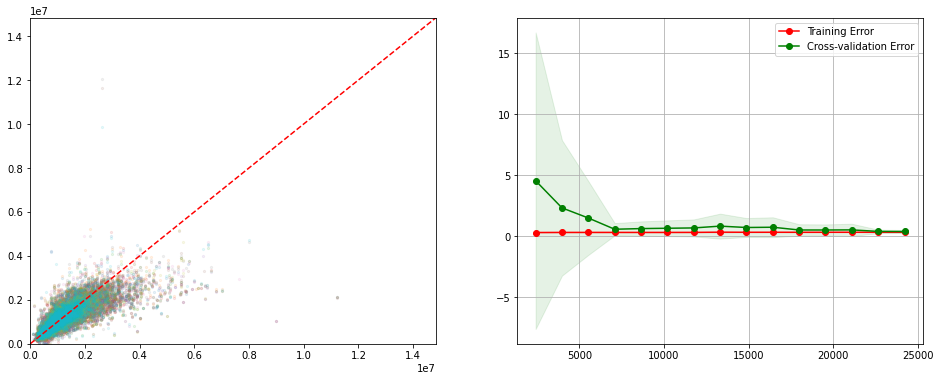

In [205]:
poly_acc = pd.DataFrame()
for x in range(1, len(X.columns) + 1):
    X_best = SelectKBest(chi2, k=x).fit_transform(X_scaled, y)
    X_poly = poly_feat.fit_transform(X_best)
    poly_reg, Summary_LR = PrintResults(poly_reg,
                                      X_poly,
                                      y,
                                      'Linear Regression')
    poly_acc = poly_acc.append(Summary_LR)

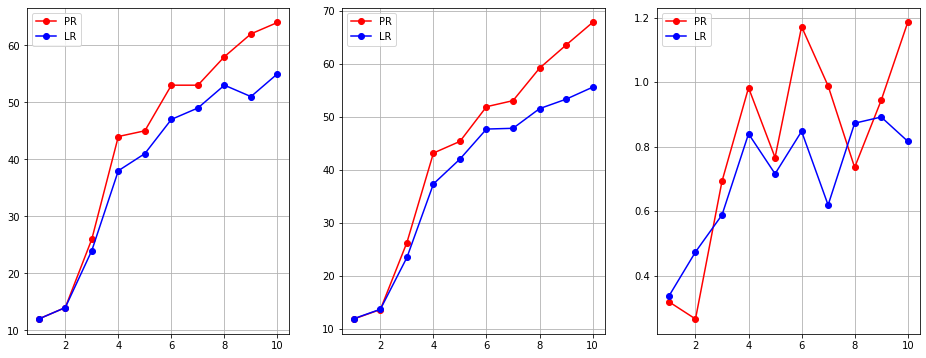

In [206]:
plt.figure(figsize = (16,6))
plt.subplot(1,3,1)
plt.plot([*range(1, len(X.columns)+1)], poly_acc.Accuracy, 'o-', color = "r",label = "PR")
plt.plot([*range(1, len(X.columns)+1)], lin_acc.Accuracy, 'o-', color = "b",label = "LR")
plt.legend(loc = "best")
plt.grid(True)
plt.subplot(1,3,2)
plt.plot([*range(1, len(X.columns)+1)], poly_acc['Score Mean'], 'o-', color = "r",label = "PR")
plt.plot([*range(1, len(X.columns)+1)], lin_acc['Score Mean'], 'o-', color = "b",label = "LR")
plt.legend(loc = "best")
plt.grid(True)
plt.subplot(1,3,3)
plt.plot([*range(1, len(X.columns)+1)], poly_acc['Score St Dv'], 'o-', color = "r",label = "PR")
plt.plot([*range(1, len(X.columns)+1)], lin_acc['Score St Dv'], 'o-', color = "b",label = "LR")
plt.legend(loc = "best")
plt.grid(True)

### Forest tree count

Model Time: 0.27 s
Total Time: 27.43 s
Scoring Accuracy: 74.00 %
Scoring Mean: 95.02 %
Scoring Standard Deviation: 0.2350 %
Model Time: 0.51 s
Total Time: 53.18 s
Scoring Accuracy: 76.00 %
Scoring Mean: 95.78 %
Scoring Standard Deviation: 0.1916 %
Model Time: 0.77 s
Total Time: 75.12 s
Scoring Accuracy: 75.00 %
Scoring Mean: 95.98 %
Scoring Standard Deviation: 0.1717 %
Model Time: 0.82 s
Total Time: 98.02 s
Scoring Accuracy: 76.00 %
Scoring Mean: 96.21 %
Scoring Standard Deviation: 0.1485 %
Model Time: 1.13 s
Total Time: 124.67 s
Scoring Accuracy: 76.00 %
Scoring Mean: 96.22 %
Scoring Standard Deviation: 0.1653 %
Model Time: 1.23 s
Total Time: 144.97 s
Scoring Accuracy: 77.00 %
Scoring Mean: 96.30 %
Scoring Standard Deviation: 0.1531 %
Model Time: 1.43 s
Total Time: 168.14 s
Scoring Accuracy: 78.00 %
Scoring Mean: 96.37 %
Scoring Standard Deviation: 0.1401 %
Model Time: 1.62 s
Total Time: 191.89 s
Scoring Accuracy: 77.00 %
Scoring Mean: 96.34 %
Scoring Standard Deviation: 0.1750 %
Mode

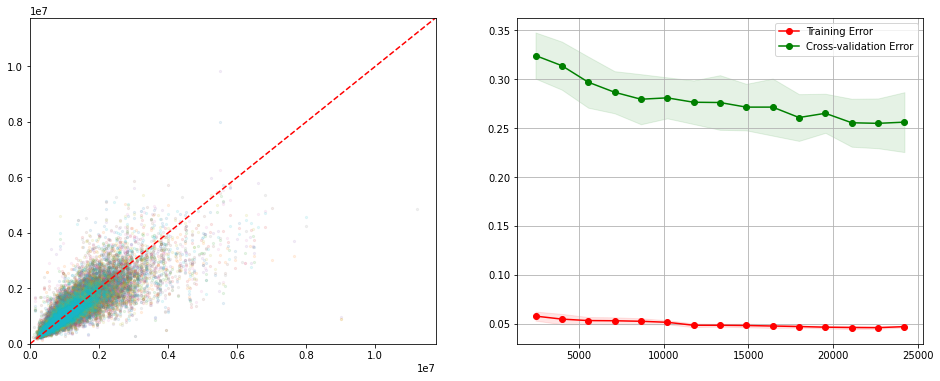

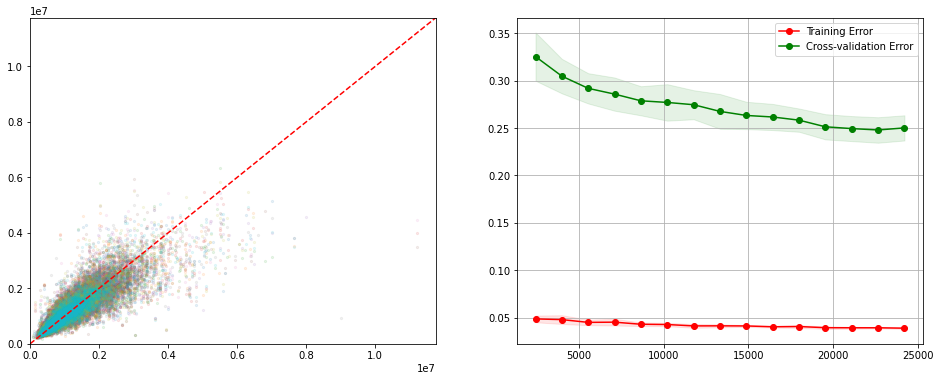

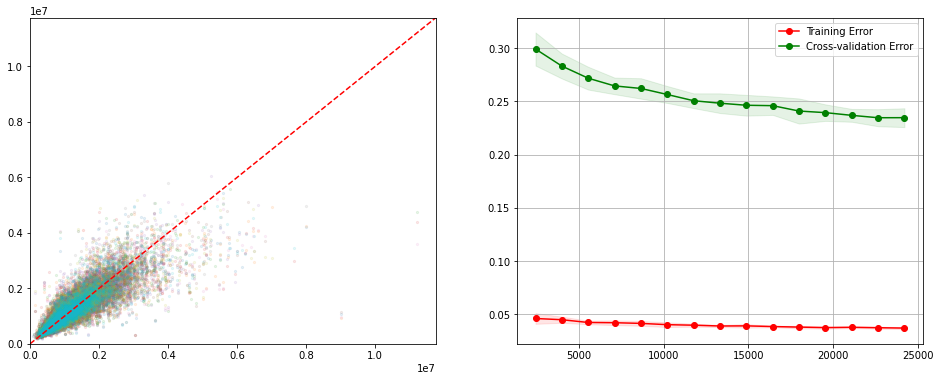

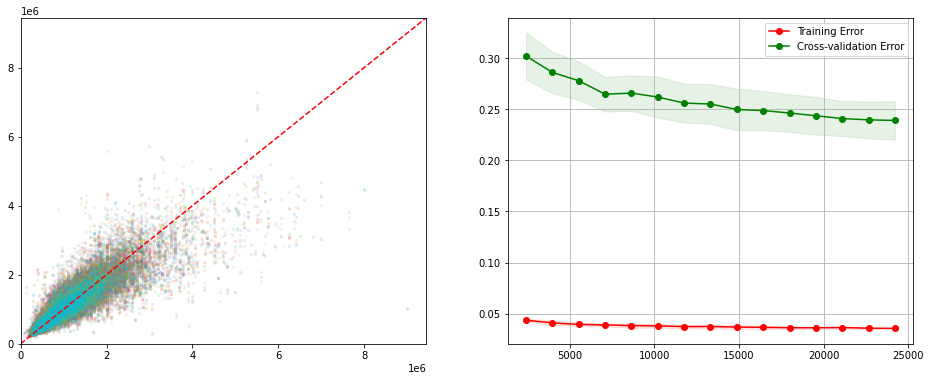

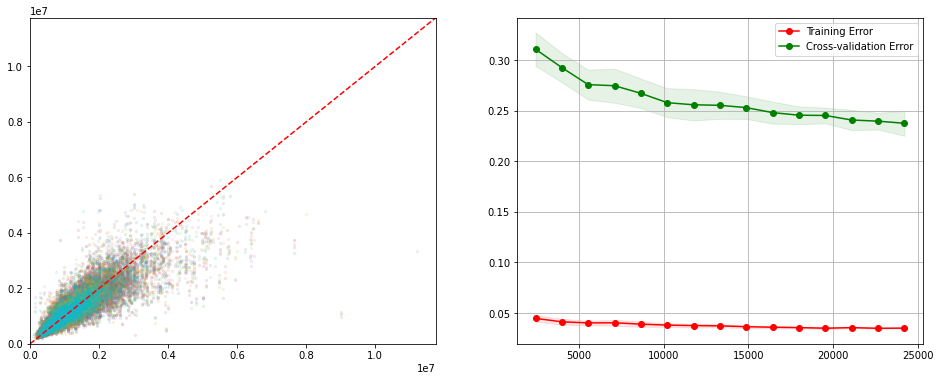

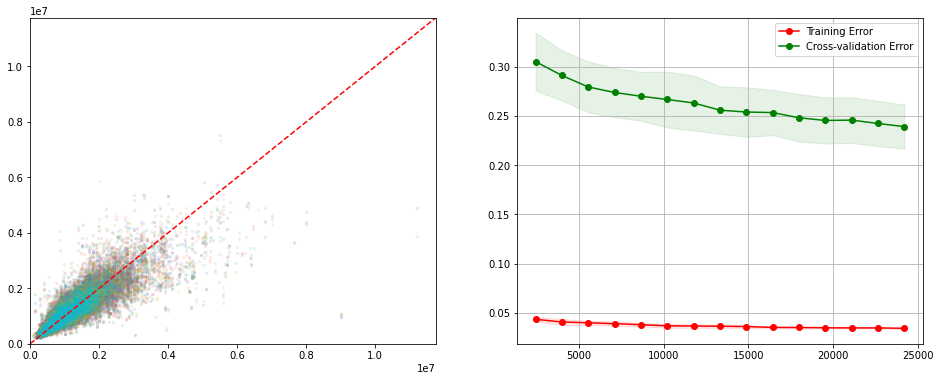

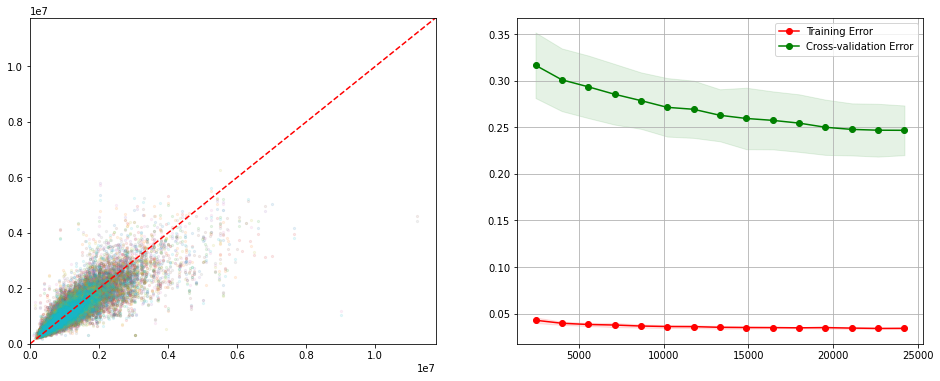

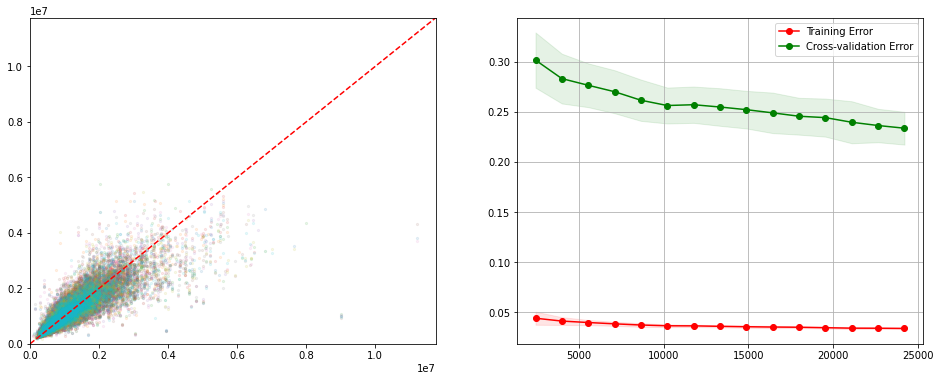

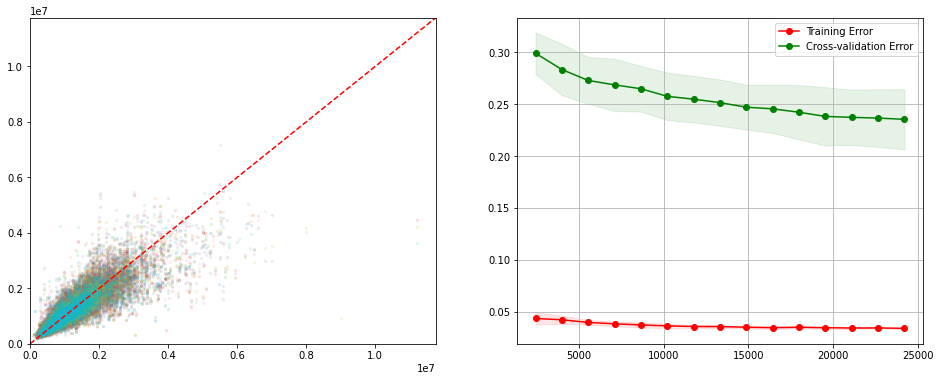

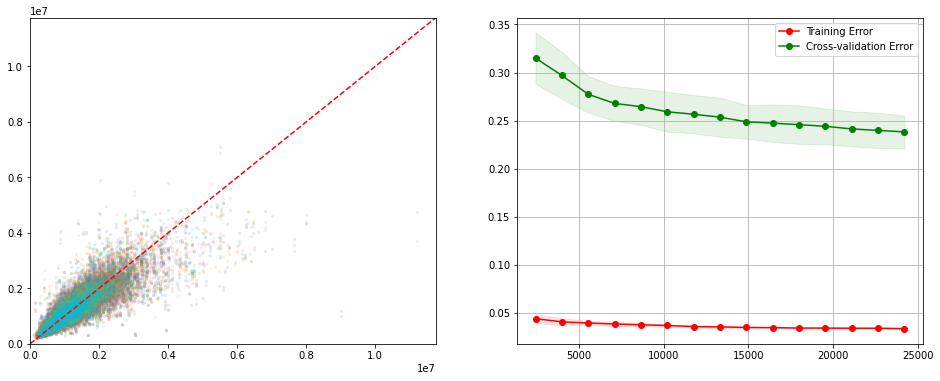

In [200]:
ntree_acc = pd.DataFrame()
for n in range(10,101,10):
    ntree_reg = RandomForestRegressor(n_jobs=-1, n_estimators=n)
    ntree_reg, Summary_FR = PrintResults(ntree_reg,
                                      X_scaled,
                                      y,
                                      'Random Forest')
    ntree_acc = ntree_acc.append(Summary_FR)

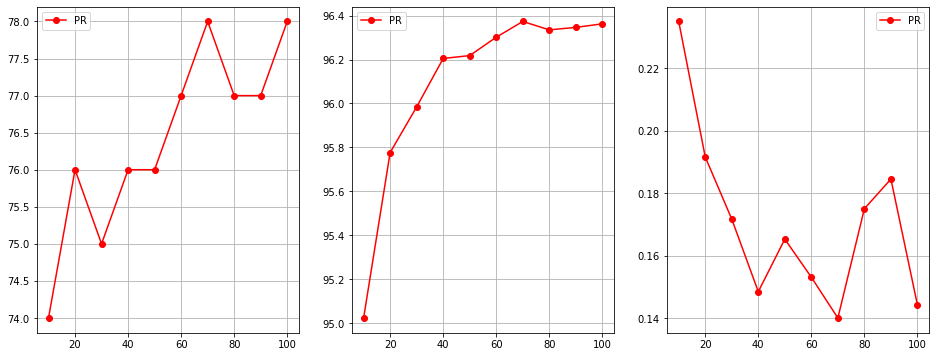

In [202]:
plt.figure(figsize = (16,6))
plt.subplot(1,3,1)
plt.plot([*range(10,101,10)], ntree_acc.Accuracy, 'o-', color = "r",label = "PR")
plt.legend(loc = "best")
plt.grid(True)
plt.subplot(1,3,2)
plt.plot([*range(10,101,10)], ntree_acc['Score Mean'], 'o-', color = "r",label = "PR")
plt.legend(loc = "best")
plt.grid(True)
plt.subplot(1,3,3)
plt.plot([*range(10,101,10)], ntree_acc['Score St Dv'], 'o-', color = "r",label = "PR")
plt.legend(loc = "best")
plt.grid(True)

### Forest tree depth

Model Time: 0.26 s
Total Time: 32.73 s
Scoring Accuracy: 39.00 %
Scoring Mean: 41.61 %
Scoring Standard Deviation: 0.8617 %
Model Time: 0.36 s
Total Time: 38.78 s
Scoring Accuracy: 49.00 %
Scoring Mean: 52.90 %
Scoring Standard Deviation: 0.8382 %
Model Time: 0.47 s
Total Time: 48.09 s
Scoring Accuracy: 57.00 %
Scoring Mean: 60.19 %
Scoring Standard Deviation: 0.5698 %
Model Time: 0.44 s
Total Time: 55.03 s
Scoring Accuracy: 63.00 %
Scoring Mean: 66.94 %
Scoring Standard Deviation: 0.7565 %
Model Time: 0.59 s
Total Time: 63.56 s
Scoring Accuracy: 67.00 %
Scoring Mean: 71.50 %
Scoring Standard Deviation: 0.6227 %
Model Time: 0.63 s
Total Time: 70.55 s
Scoring Accuracy: 70.00 %
Scoring Mean: 75.72 %
Scoring Standard Deviation: 0.6947 %
Model Time: 0.70 s
Total Time: 78.59 s
Scoring Accuracy: 72.00 %
Scoring Mean: 78.94 %
Scoring Standard Deviation: 0.5257 %
Model Time: 0.80 s
Total Time: 88.42 s
Scoring Accuracy: 73.00 %
Scoring Mean: 82.39 %
Scoring Standard Deviation: 0.5188 %
Model Ti

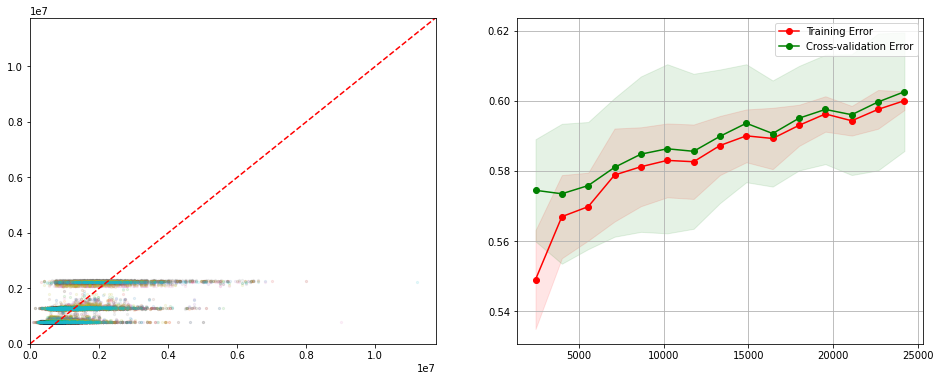

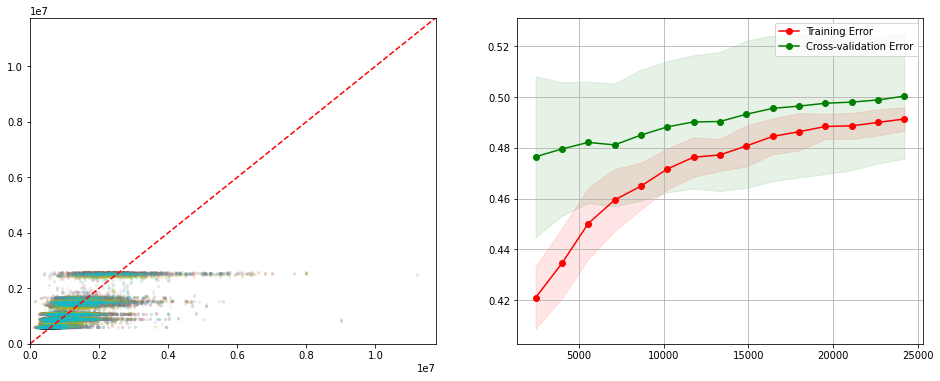

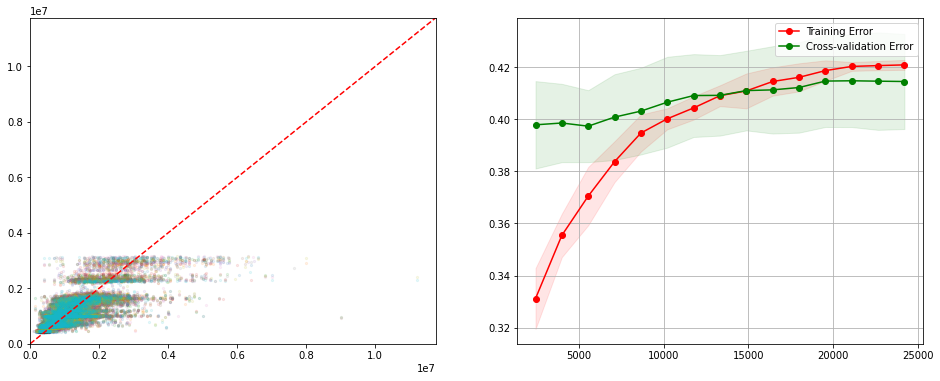

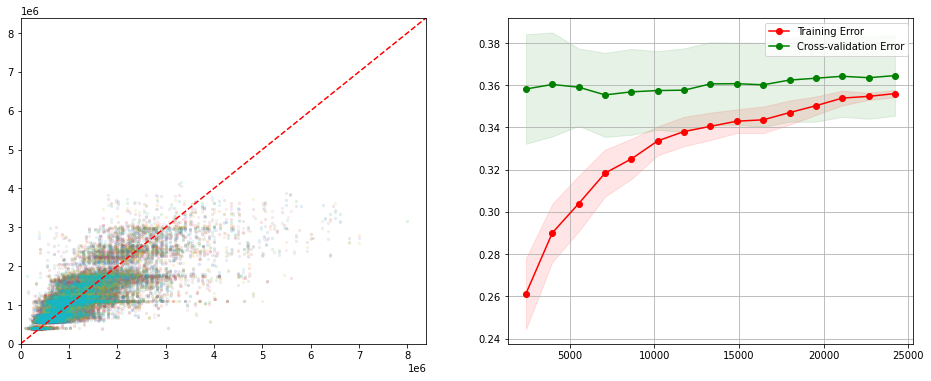

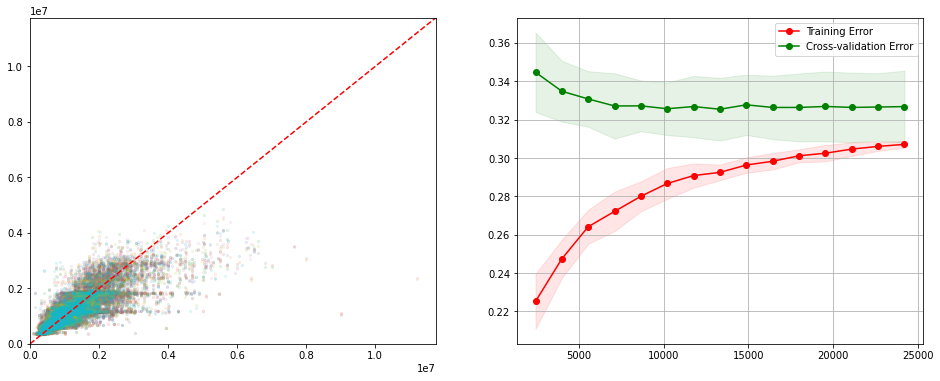

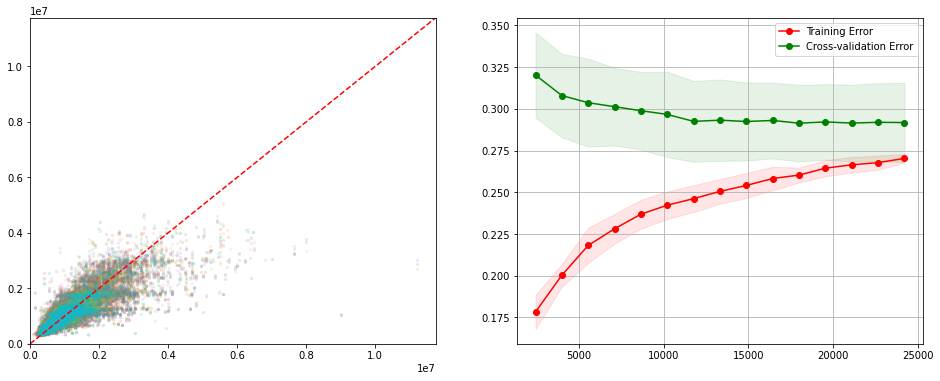

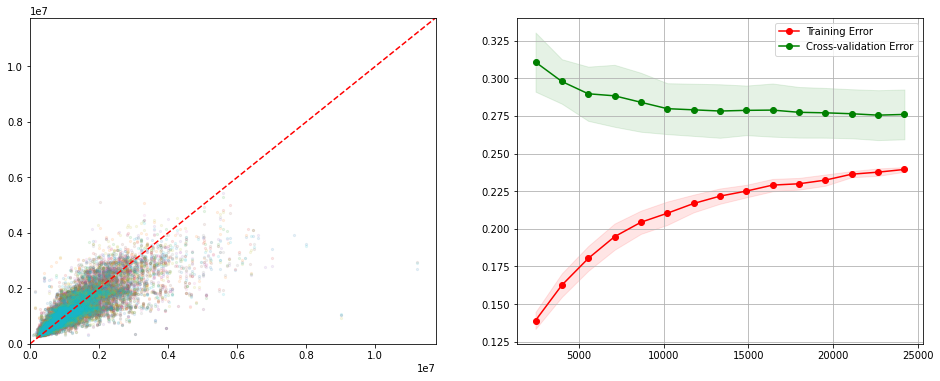

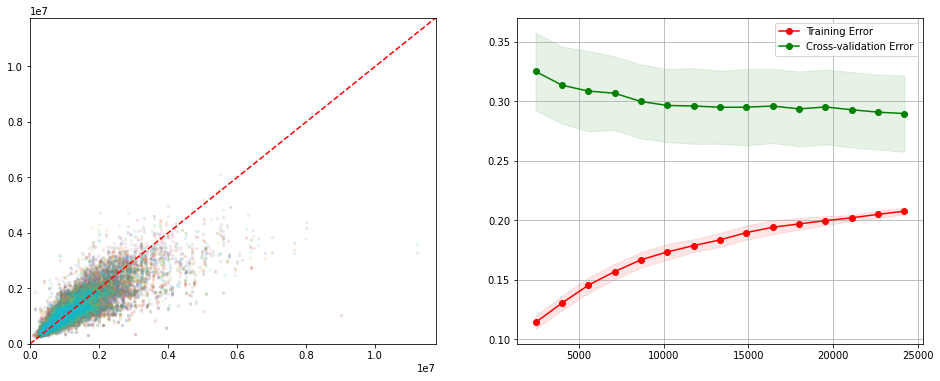

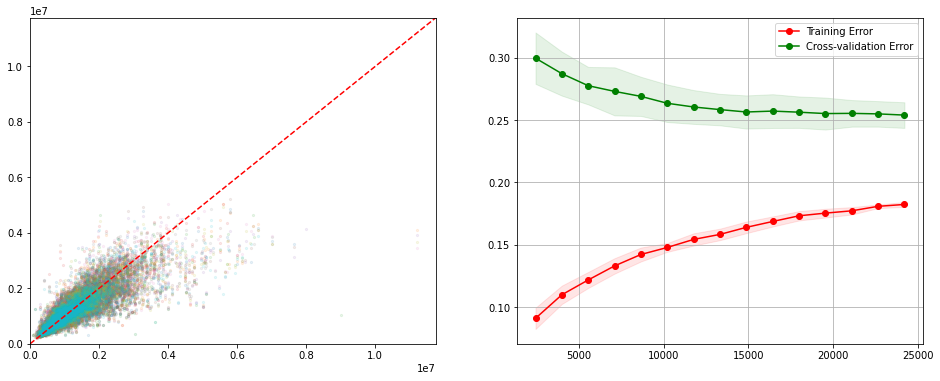

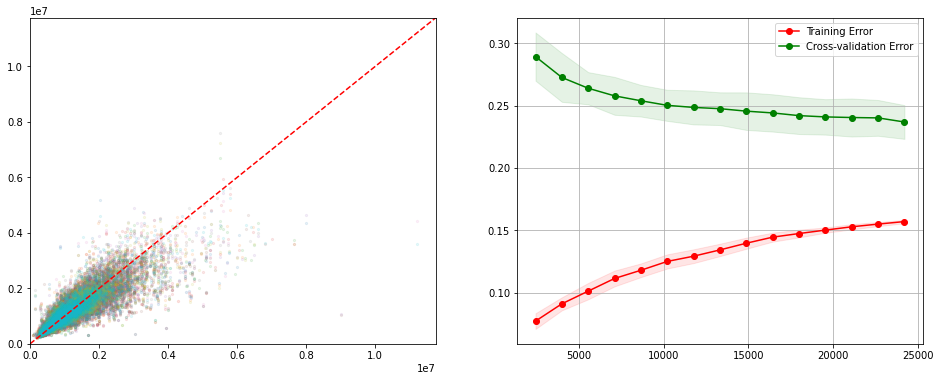

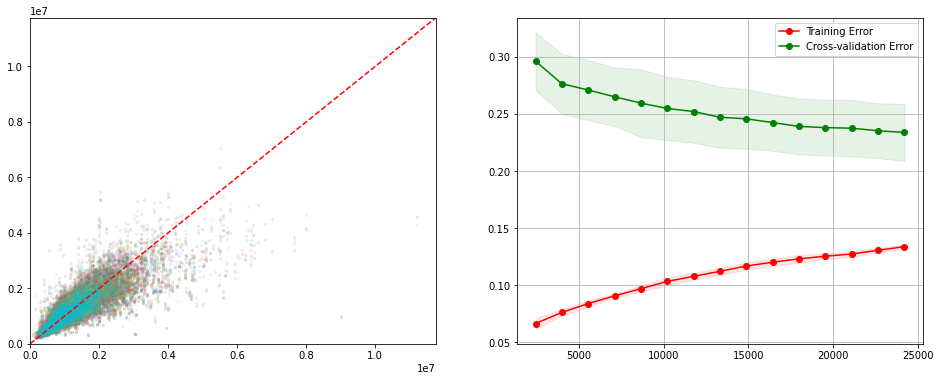

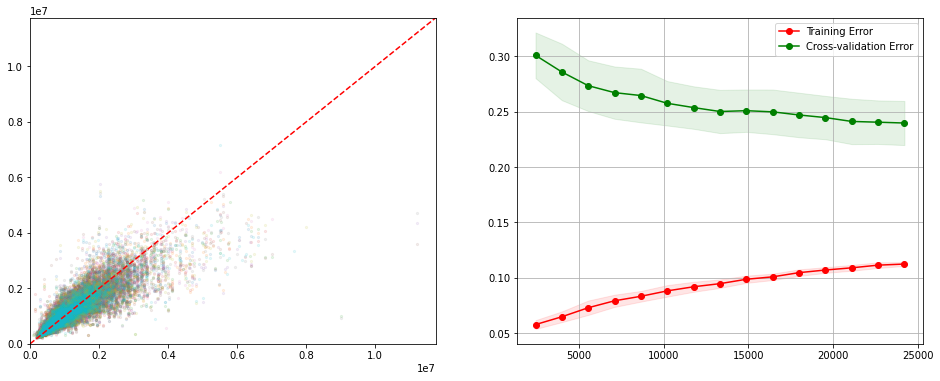

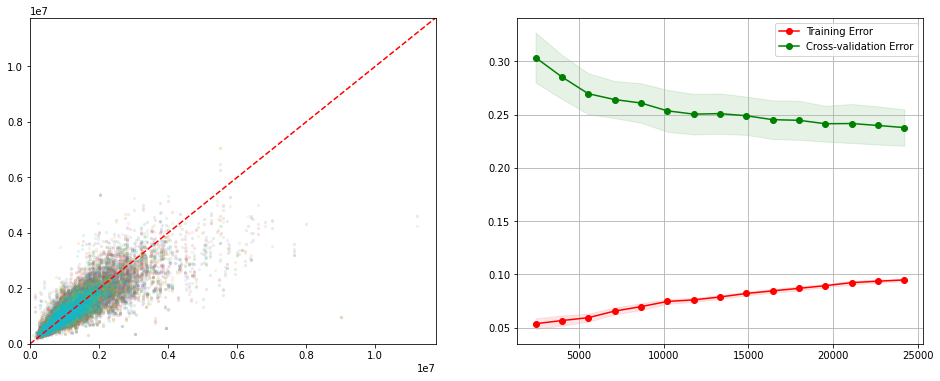

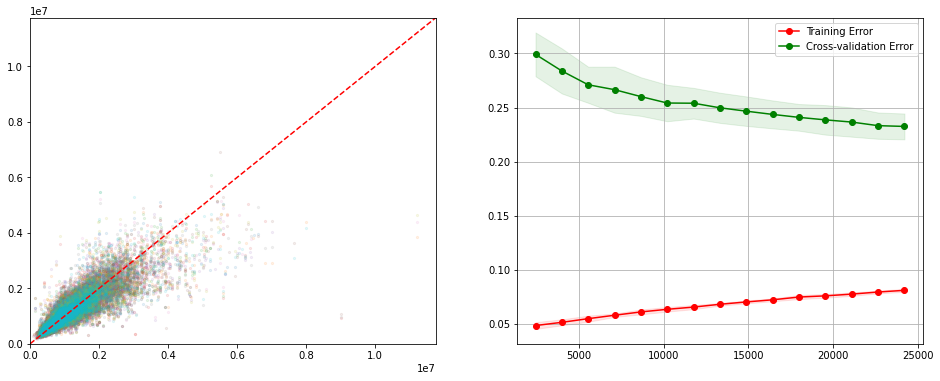

In [203]:
n=70
dtree_acc = pd.DataFrame()
for d in range(2,16):
    dtree_reg = RandomForestRegressor(n_jobs=-1, n_estimators=n, max_depth=d)
    dtree_reg, Summary_FR = PrintResults(dtree_reg,
                                      X_scaled,
                                      y,
                                      'Random Forest')
    dtree_acc = dtree_acc.append(Summary_FR)

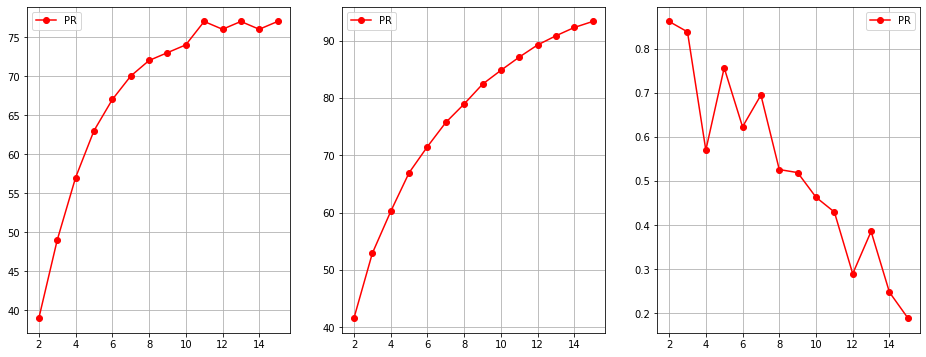

In [204]:
plt.figure(figsize = (16,6))
plt.subplot(1,3,1)
plt.plot([*range(2,16)], dtree_acc.Accuracy, 'o-', color = "r",label = "PR")
plt.legend(loc = "best")
plt.grid(True)
plt.subplot(1,3,2)
plt.plot([*range(2,16)], dtree_acc['Score Mean'], 'o-', color = "r",label = "PR")
plt.legend(loc = "best")
plt.grid(True)
plt.subplot(1,3,3)
plt.plot([*range(2,16)], dtree_acc['Score St Dv'], 'o-', color = "r",label = "PR")
plt.legend(loc = "best")
plt.grid(True)

### Final run

Model Time: 0.87 s
Total Time: 112.36 s
Scoring Accuracy: 76.00 %
Scoring Mean: 87.16 %
Scoring Standard Deviation: 0.4449 %
Model Time: 0.12 s
Total Time: 10.30 s
Scoring Accuracy: 65.00 %
Scoring Mean: 68.08 %
Scoring Standard Deviation: 0.7804 %


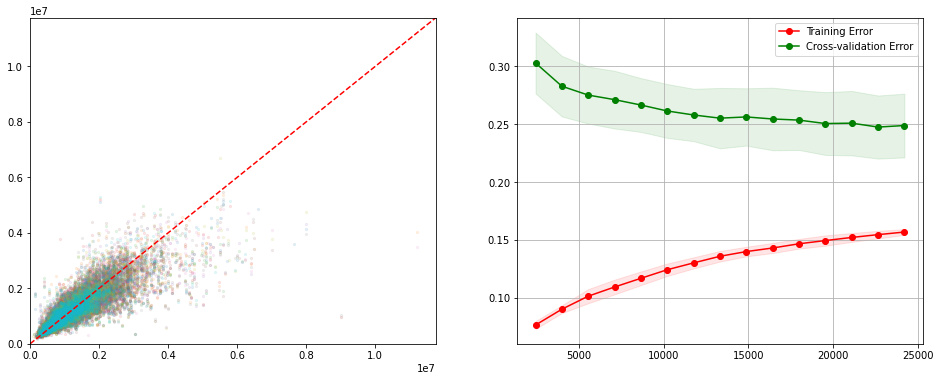

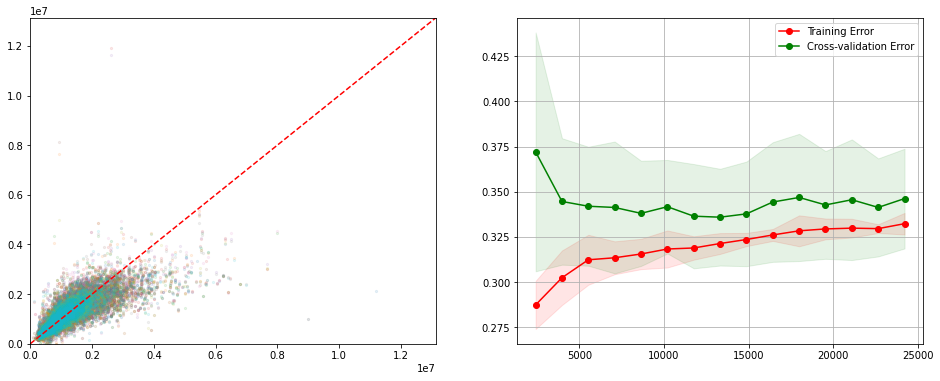

In [207]:
for_final = RandomForestRegressor(n_jobs=-1, n_estimators=70, max_depth=11)
lin_final = LinearRegression(n_jobs=-1)
poly_feat = PolynomialFeatures(degree=2)

for_final, Summary_FR = PrintResults(for_final,
                                      X_scaled,
                                      y,
                                      'Random Forest')
lin_final, Summary_LR = PrintResults(lin_final,
                                      poly_feat.fit_transform(X_scaled),
                                      y,
                                      'Linear Regression')